# Ajinomoto Data Analysis Notebook

In this notebook we compile all assays performed for the Ajinomoto Project that were designed to produce the C12 Fatty alcohol dodecanol. Both Cycle 1 data and Cycle 2 data are considered seperately and together.

## Initial Setup

1. **Data Import and Quality Checking:** Data is integrated from multiple sources and checked for quality. Corrections are made when possible and data quality is reported.

## Cycle 1 Data Analysis

1. **Basic Univariate and Bivariate Analysis:** Bivariate analyses are performed to look for statistically significant correlations in the data.  Some of these correlations are plotted.  Histograms of important varibles are also plotted.

2. **Machine Learning Prediction of Next Strains to Construct:** Proteomics, Strain Design Variables, and production are correlated using the automated reccomendation tool (ART).  ART is used to search for machine learning models that explain the data. These models are then searched for a set of 10 candidate strains which will best improve dodecanol production.  These are reported for construction in the second round of designs.

## Cycle 2 Data Analysis

1. ** RBS vs Proteomics Correlational Analisys:** We look to see if there is a relationship between RBS and protein expression.

2. ** Proteomics Analysis: ** We look at the proteomics of all of our designs and evaluate how close they were to hitting their engineering targets.

3. **Predictions for Cycle 1 Are Checked against Values for Cycle 2:**  How well did we do with our predictions? We analyze the performance of cycle 1 models to predict the cycle 2 data. 

4. ** Predictions for Round 3: ** We produce a set of predictions for a third round if we were to perform it.

### 1.1 Cycle 1: Data Import & QC
Below is the code used to import, unify, and check all of the data from a set of CSVs.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display,HTML
from tpot import TPOTRegressor
from plot import *
import itertools
import sys


#Sklearn Imports 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

#Import Plotting Tools
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Helper Functions (May Move to own file later)
#Calculate Replicate Variance for each measurement
def mean_percent_deviation(col):
    mean = col.mean()
    if mean == 0:
        return 0
    else:
        return np.mean(abs(col-mean))/mean*100
    
    
def analyze_replicate_error(columns,log=True):
    means = []
    percents = []
    pathway = []
    for group in df.groupby([('Metadata','Batch'),('Metadata','Tak')]):
        
        replicate_df = group[1]
        
        #Calculate Mean Value
        means += replicate_df.iloc[:, columns].mean().values.tolist()
        
        #Mean Percent Deviation
        percents += replicate_df.iloc[:, columns].fillna(0).apply(mean_percent_deviation,axis=0).values.tolist()
        
        #Pathway Number
        pathway.append(float(replicate_df[('Metadata','Pathway Variant')].values[0]))
    
        
    #Create Figures
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,2)
    sns.distplot(percents,norm_hist=True)
    plt.title('Percent Error Distribution (Mean Error: {:.1f}%)'.format(np.mean(percents)))
    plt.ylabel('Relative Frequency')
    plt.xlabel('Replicate Percent Error')
    
    plt.subplot(1,2,1)
    if log:
        log_means = np.log10(means)
        plt.scatter(log_means,percents)
    else:
        plt.scatter(means,percents)
        
    
        
def display_high_error_measurements(columns,tolerance,file=None):
    if file is not None:
        f = open(file, 'w')
    else:
        f = sys.stdout
        
    print('Measurements to ReCheck!',file=f)
    print('========================',file=f)
    for group in df.groupby([('Metadata','Batch'),('Metadata','Tak')]):
            replicate_df = group[1].iloc[:, columns]
            #Calculate Mean Value
            means = replicate_df.mean()
            #Mean Percent Deviation
            percents = replicate_df.apply(mean_percent_deviation,axis=0)
            #print(percents)
            for percent,measurement in zip(percents,percents.index):
                if percent > tolerance:
                    print(replicate_df[measurement],file=f)
                    print('Percent Error',percent,file=f)
                    print('------------------------',file=f)
                    #Print Measurement, Strains In Question, & Percent Error
    
    if file is not None:
        f.close()

Data is loaded from a CSV downloaded from the edd study [Ajinomoto Cycle 1](https://edd.jbei.org/s/test-4838/).

In [3]:
#Load Experimental Measurement Data
df = pd.read_csv('data/ajinomoto_oct23.csv')

A pandas data frame is constructed which will house all of the measurements.

In [4]:
#Create a Dataframe of Protein and Metabolite Single Time Point Measurement
measurement_df = pd.pivot_table(df, values=['0.0','27.0'], index=['Line Name'], columns=['Protocol Name','Measurement Type']).fillna(0)
measurement_df.columns = measurement_df.columns.droplevel(0)

In [5]:
#Drop HPLC Measurements that are not Glucose or Acetate
bad_hplc_measurements = [ ('HPLC', 'D-Lactate'), ('HPLC', 'Formate'), ('HPLC', 'Pyruvate'), ('HPLC', 'Succinate')]
for measurement in bad_hplc_measurements:
    measurement_df = measurement_df.drop(measurement,1)
display(measurement_df)

Protocol Name    Targeted Proteomics                                    \
Measurement Type        A1U2T0_MARHV A1U3L3_MARHV ACR1_ACIAD AHR_ECOLI   
Line Name                                                                
b1-01-1                       1800.0     159144.0        0.0     125.0   
b1-01-2                          0.0     173165.0        0.0       0.0   
b1-02-1                          0.0     158408.0      396.0     530.0   
b1-02-2                       1744.0     155221.0        0.0     470.0   
b1-04-1                       1862.0     565758.0        0.0     431.0   
b1-04-2                          0.0     579082.0     1352.0     286.0   
b1-08-1                          0.0     202718.0        0.0       0.0   
b1-08-2                          0.0     204510.0        0.0       0.0   
b1-09-1                       8828.0     207289.0        0.0       0.0   
b1-09-2                          0.0     232565.0        0.0       0.0   
b1-11-1                          0.0     686451.0        0.0       0.0   
b1-11-2                          0.0     736006.0        0.0     380.0   
b1-12-1                        352.0     740579.0        0.0    1650.0   
b1-12-2                          0.0     762921.0        0.0     669.0   
b1-15-1                       8372.0       8555.0        0.0       0.0   
b1-15-2                      10438.0       3483.0        0.0     307.0   
b1-16-1                      21091.0       2518.0        0.0     188.0   
b1-16-2                       8954.0          0.0        0.0       0.0   
b1-22-1                       2045.0          0.0    44506.0  184852.0   
b1-22-2                       2344.0          0.0    37032.0  170458.0   
b1-9017-1                    25770.0          0.0        0.0    1624.0   
b1-9017-2                    21323.0          0.0        0.0    1828.0   
b1-rfp-1                   1109594.0        313.0     1203.0    1033.0   
b1-rfp-2                   1086861.0          0.0        0.0     695.0   
b2-11-1                       1149.0     360114.0        0.0       0.0   
b2-11-2                       3377.0     405148.0        0.0     331.0   
b2-11-3                          0.0     400045.0        0.0       0.0   
b2-19-1                     192296.0      10156.0     1117.0    1627.0   
b2-19-2                     171189.0       3105.0     1577.0    1328.0   
b2-19-3                     151364.0          0.0        0.0     795.0   
...                              ...          ...        ...       ...   
b3-08-1                          0.0      87508.0        0.0     378.0   
b3-08-2                        512.0      87744.0      814.0       0.0   
b3-08-3                          0.0      82715.0        0.0     657.0   
b3-10-1                        736.0     499232.0      644.0       0.0   
b3-10-2                        376.0     532764.0      610.0       0.0   
b3-10-3                          0.0     503145.0        0.0       0.0   
b3-13-1                      12448.0       8602.0        0.0     887.0   
b3-13-2                      12835.0          0.0        0.0    1376.0   
b3-13-3                      10366.0          0.0        0.0       0.0   
b3-16-1                       4053.0          0.0        0.0       0.0   
b3-16-2                       3475.0          0.0      452.0       0.0   
b3-16-3                       9574.0          0.0        0.0     527.0   
b3-18-1                     215377.0        400.0        0.0    1663.0   
b3-18-2                     203658.0       1671.0        0.0     814.0   
b3-18-3                     172397.0          0.0        0.0     822.0   
b3-21-1                       1655.0          0.0    13405.0  146386.0   
b3-21-2                          0.0          0.0    14472.0  145548.0   
b3-21-3                        942.0       2348.0    15854.0  153728.0   
b3-23-1                          0.0          0.0    35029.0  169309.0   
b3-23-2                       1876.0          0.0    38909.0  168464.0   
b3-2

Auxillary columns are created for Total Fatty Alcohols, Total Protein Counts, Glucose Consumed, and Dodecanol Yeild.

In [6]:
#Add a Total Fatty Alcohols Column!
fatty_acid_columns = [('GC-MS', 'Dodecanoate (n-C12:0)'),('GC-MS', 'Hexadecanoate (n-C16:0)'), ('GC-MS', 'Octadecanoate (n-C18:0)'), ('GC-MS', 'Tetradecanoate (n-C14:0)')]
measurement_df[('GC-MS','Total Fatty Alcohols')] = measurement_df[fatty_acid_columns].sum(axis=1)
#display(measurement_df[('GC-MS','Total Fatty Alcohols')])

In [7]:
#Add a Total Proteins Column!
measurement_df[('Targeted Proteomics','Total Protein')] = measurement_df['Targeted Proteomics'].sum(axis=1)

In [8]:
#Create a Glucose Consumed Column
display(measurement_df)
starting_glucose = 20 #20 Grams Per Liter Starting
measurement_df[('HPLC','Glucose Consumed')] = 20 - measurement_df[('HPLC','D-Glucose')]

Protocol Name    Targeted Proteomics                                    \
Measurement Type        A1U2T0_MARHV A1U3L3_MARHV ACR1_ACIAD AHR_ECOLI   
Line Name                                                                
b1-01-1                       1800.0     159144.0        0.0     125.0   
b1-01-2                          0.0     173165.0        0.0       0.0   
b1-02-1                          0.0     158408.0      396.0     530.0   
b1-02-2                       1744.0     155221.0        0.0     470.0   
b1-04-1                       1862.0     565758.0        0.0     431.0   
b1-04-2                          0.0     579082.0     1352.0     286.0   
b1-08-1                          0.0     202718.0        0.0       0.0   
b1-08-2                          0.0     204510.0        0.0       0.0   
b1-09-1                       8828.0     207289.0        0.0       0.0   
b1-09-2                          0.0     232565.0        0.0       0.0   
b1-11-1                          0.0     686451.0        0.0       0.0   
b1-11-2                          0.0     736006.0        0.0     380.0   
b1-12-1                        352.0     740579.0        0.0    1650.0   
b1-12-2                          0.0     762921.0        0.0     669.0   
b1-15-1                       8372.0       8555.0        0.0       0.0   
b1-15-2                      10438.0       3483.0        0.0     307.0   
b1-16-1                      21091.0       2518.0        0.0     188.0   
b1-16-2                       8954.0          0.0        0.0       0.0   
b1-22-1                       2045.0          0.0    44506.0  184852.0   
b1-22-2                       2344.0          0.0    37032.0  170458.0   
b1-9017-1                    25770.0          0.0        0.0    1624.0   
b1-9017-2                    21323.0          0.0        0.0    1828.0   
b1-rfp-1                   1109594.0        313.0     1203.0    1033.0   
b1-rfp-2                   1086861.0          0.0        0.0     695.0   
b2-11-1                       1149.0     360114.0        0.0       0.0   
b2-11-2                       3377.0     405148.0        0.0     331.0   
b2-11-3                          0.0     400045.0        0.0       0.0   
b2-19-1                     192296.0      10156.0     1117.0    1627.0   
b2-19-2                     171189.0       3105.0     1577.0    1328.0   
b2-19-3                     151364.0          0.0        0.0     795.0   
...                              ...          ...        ...       ...   
b3-08-1                          0.0      87508.0        0.0     378.0   
b3-08-2                        512.0      87744.0      814.0       0.0   
b3-08-3                          0.0      82715.0        0.0     657.0   
b3-10-1                        736.0     499232.0      644.0       0.0   
b3-10-2                        376.0     532764.0      610.0       0.0   
b3-10-3                          0.0     503145.0        0.0       0.0   
b3-13-1                      12448.0       8602.0        0.0     887.0   
b3-13-2                      12835.0          0.0        0.0    1376.0   
b3-13-3                      10366.0          0.0        0.0       0.0   
b3-16-1                       4053.0          0.0        0.0       0.0   
b3-16-2                       3475.0          0.0      452.0       0.0   
b3-16-3                       9574.0          0.0        0.0     527.0   
b3-18-1                     215377.0        400.0        0.0    1663.0   
b3-18-2                     203658.0       1671.0        0.0     814.0   
b3-18-3                     172397.0          0.0        0.0     822.0   
b3-21-1                       1655.0          0.0    13405.0  146386.0   
b3-21-2                          0.0          0.0    14472.0  145548.0   
b3-21-3                        942.0       2348.0    15854.0  153728.0   
b3-23-1                          0.0          0.0    35029.0  169309.0   
b3-23-2                       1876.0          0.0    38909.0  168464.0   
b3-2

In [9]:
#Create Yeild Column (Production per gram of D-Glucose)
measurement_df[('GC-MS','Dodecanoate Yeild')] = measurement_df[('GC-MS','Dodecanoate (n-C12:0)')] / measurement_df[('HPLC','Glucose Consumed')]
#display(measurement_df['GC-MS'].sort_values('Dodecanoate Yeild',ascending=False))
#display(measurement_df['GC-MS'].sort_values('Dodecanoate (n-C12:0)',ascending=False))

A pandas dataframe for experimental design parameters is constructed from a CSV of the strain designs.

In [10]:
#Load Design data from ICE
design_df = df[['Line Name','Strain']]
design_df = design_df.groupby(['Line Name','Strain']).size().reset_index().set_index('Line Name')[['Strain']]

#Add Batch Number, Tak Number, and Replicate
identifiers = [index.split('-') for index in design_df.index]
identifiers = [[int(identifier[0][1]), int(identifier[1]), int(identifier[2])] for identifier in identifiers]
design_df[['Batch','Tak','Replicate']] = pd.DataFrame(identifiers, index=design_df.index)

#Add Design Information (RBS Strength To Each Design For Each Protein)
rbs_df = pd.read_csv('data/design.csv')
indecies = design_df.index
design_df = pd.merge(design_df,rbs_df,how='left',on="Tak")
design_df.index = indecies

#Add Pathway Variant ID
design_df['Pathway Variant'] = 0
pathway_genes = ['Maqu_2507','Maqu_2220','acr1']
for i,pathway_gene in enumerate(pathway_genes):
    #Find Indecies Where Pathway Gene is present
    design_df['Pathway Variant'].loc[~design_df[pathway_gene].isnull()] = i+1
    
design_df.columns = pd.MultiIndex.from_tuples([('Metadata',cname) for cname in design_df.columns])

/Users/zakcostello/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Metabolomics Data from is added to the measurement data frame.

In [11]:
metabolomics_df = pd.read_csv('data/metabolomics.csv')
columns = ['Decanoic acid', 'Lauric acid', 'Myristic acid', 'Palmitic acid',
           'Stearic acid', 'Palmitoleic acid', 'Oleic acid']#, 'Dodecanoyl-CoA',
           #'Tetradecanoyl-CoA', 'Hexadecanoyl-CoA', 'Stearoyl-CoA', 'Acetyl-CoA']
augmented_cols = pd.MultiIndex.from_tuples([('LC-MS',col) for col in columns])
metabolomics_df = metabolomics_df.set_index('EDD Line Name')
metabolomics_df = metabolomics_df[columns]
metabolomics_df.columns = augmented_cols
metabolomics_df = metabolomics_df.fillna(0)
#print(metabolomics_df.columns)

#display(metabolomics_df)
#print(list(measurement_df['LC-MS'].columns))
#print(list(measurement_df.columns))
#print(list(metabolomics_df.columns))

NIMs Data is loaded from a CSV and added to the measurement dataframe. Technical Replicates are measured for agreement and quality.  The results are plotted.

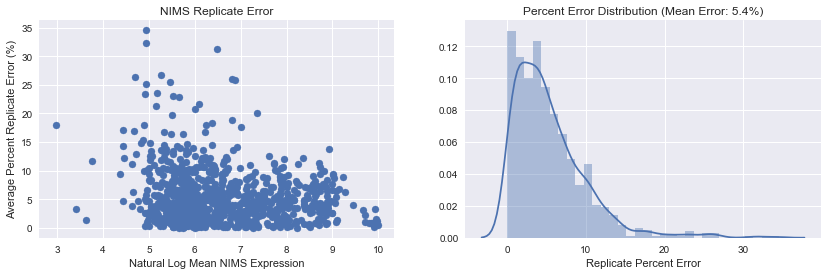

In [12]:
#Load Nims Data into Dataframe
nims_df = pd.read_csv('data/nims.csv')
#nims_df = nims_df.set_index('Unnamed: 0')

#Group Technical Replicates & Evaluate How Close they are!
means = []
percents = []
log=True


for group in nims_df.groupby('Unnamed: 0'):
    #display(group[1].mean())
    means += group[1].mean().values.tolist()
    percents += group[1].set_index('Unnamed: 0').apply(mean_percent_deviation).values.tolist()
    
#Create Figures
plt.figure(figsize=(14,4))
    
plt.subplot(1,2,2)
sns.distplot(percents)
plt.title('Percent Error Distribution (Mean Error: {:.1f}%)'.format(np.mean(percents)))
plt.xlabel('Replicate Percent Error')
    
plt.subplot(1,2,1)
if log:
    log_means = np.log(means)
    plt.scatter(log_means,percents)
else:
    plt.scatter(means,percents)
    
plt.title('NIMS Replicate Error')
plt.xlabel('Natural Log Mean NIMS Expression')
plt.ylabel('Average Percent Replicate Error (%)')
plt.show()
#Create Nims Dataframe with averaged replicates
#display(nims_df)

In [13]:
nims_averaged_df = nims_df.groupby('Unnamed: 0').mean()
nims_averaged_df.columns = pd.MultiIndex.from_tuples([('NIMS',col) for col in nims_averaged_df.columns])

The Strain Design Data Frame and Measurment Data Frame are Merged for downstream processing.

In [14]:
#Merge Metadata Dataframe into Measurement Dataframe
df = pd.merge(measurement_df,design_df,how='left',left_index=True,right_index=True)
df = pd.merge(df,metabolomics_df,how='left',left_index=True,right_index=True)
df = pd.merge(df,nims_averaged_df,how='left',left_index=True,right_index=True)
#display(df)

In [15]:
#Load Translation Initiation Rates Associated with Each RBS.
rbs_df = pd.read_csv('data/rbs.csv')

#Define Function to associate Translation Initiation Rate with Each Gene
def find_tir(gene,value_column='Predicted TIR'):
    def f(row):
        rbs_strength = row[('Metadata',gene)]
        if isinstance(rbs_strength,str):
            return rbs_df[(rbs_df['Gene'] == gene)&(rbs_df['Strength'] == row[('Metadata',gene)])][value_column].values[0]
        else:
            return 0        
    return f

genes = ['UcFatB1','FadD','Maqu_2507','Maqu_2220','acr1','yjgB']
for gene in genes:
    df[('TIR',gene)] = df.apply(find_tir(gene),axis=1)
    df[('EMOPEC',gene)] = df.apply(find_tir(gene,value_column='EMOPEC'),axis=1)
    measurement_df[('TIR',gene)] = df.apply(find_tir(gene),axis=1)
    measurement_df[('EMOPEC',gene)] = df.apply(find_tir(gene,value_column='EMOPEC'),axis=1)

#display(df)

### Data Quality Control

In order to ensure that experimental measurement variations accurately represent the biology instead of the assay technique we conduct a series of batch to batch constistency checks. First, we check to make sure protein is produced if and only if the associated gene is expressed.  This code triggers several warnings alerting us that there are inconsistencies between the transformed vector and the measured proteomics data. 

#### Perform Correction on (Incorrect Proteomics) Data

Some Protomics data suggests the presence of proteins in strains which were not present in the vectors. These protein counts are zeroed out to remove the spurious measurements if they are close to zero.  If they are too large, we ask the creator of the data to check the raw counts. Warnings are reported for strains/proteins that appear to be problematic.

In [16]:
#Check to Make Sure Gene Expression is What We Expect in Each Construct
detectable_threshold = 100
undetectable_threshold = 100
gene_protein_pairs = [
    ('Maqu_2220','A1U2T0_MARHV'),
    ('Maqu_2507','A1U3L3_MARHV'),
    ('acr1','ACR1_ACIAD'),
    ('yjgB','AHR_ECOLI'),
    ('UcFatB1','FATB_UMBCA'),
    ('FadD','LCFA_ECOLI')
]

strain_whitelist = ['b1-9017-1','b1-9017-2','b2-9017-1',
                    'b2-9017-2','b2-9017-3','b3-9017-1',
                    'b3-9017-2','b3-9017-3','b1-rfp-1',
                    'b1-rfp-2','b2-rfp-1','b2-rfp-2',
                    'b2-rfp-3','b3-rfp-01','b3-rfp-02',
                    'b3-rfp-03'
                   ]


gene_protein_pairs = [pd.MultiIndex.from_tuples([('Metadata',pair[0]),('Targeted Proteomics',pair[1])]) for pair in gene_protein_pairs]

#For each strain check the proposition (there is expression if and only if the gene is present)
def check_expression(column1,column2):
    def f(row):
        #display(row[[column1,column2]])
        #print(isinstance(row[column1],str))
        if row.name not in strain_whitelist:
            if isinstance(row[column1],str) and row[column2] < undetectable_threshold:            
                #Print Warning
                #display(row)
                #print('')
                #warning_string = 'WARNING: Gene ({%g}'.format(column1[1])
                #print(warning_string)
                warning_string = 'WARNING: Gene ({}) present but Protein ({}) not detected in strain {}!'.format(column1[1],column2[1],row.name)
                print(warning_string)
                #print(row[column1],row[column2])
                return 0
            elif not isinstance(row[column1],str) and row[column2] > detectable_threshold:
                #Print Warning
                #display(row)
                warning_string = 'Warning: Gene ({}) not present but Protein ({}) detected with {:d} counts in strain {}!'.format(column1[1],column2[1],int(row[column2]),row.name)
                print(warning_string)
                #print(row[column1],row[column2])
                #return row[column2]
                return 0
            
            
            if row[column2] < detectable_threshold:
                return 0
            
        return row[column2]
    return f

for pair in gene_protein_pairs:
    series = df.apply(check_expression(*pair),axis=1)
    df[pair[1]] = series
    #display(series)
    


#### Aggrigate Error for all measurement modalities is Analyzed
Each measurement modeality, Targeted Proteomics, HPLC, GC-MS, Metabolomics, and NIMs are checked for replicate agreement and plotted against the mean value of the replicates.

/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10


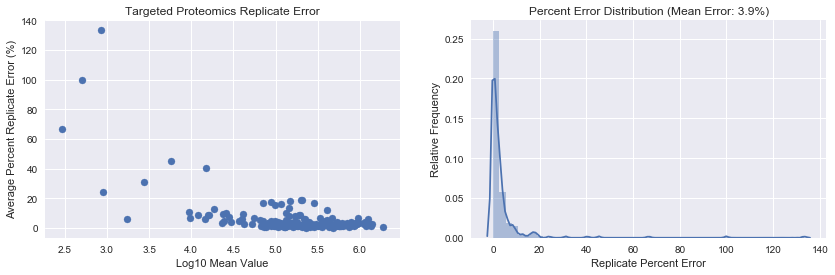

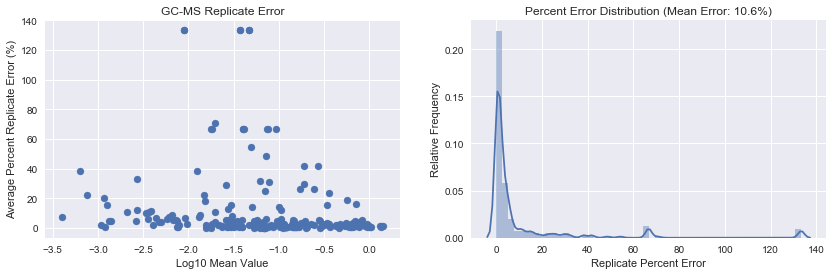

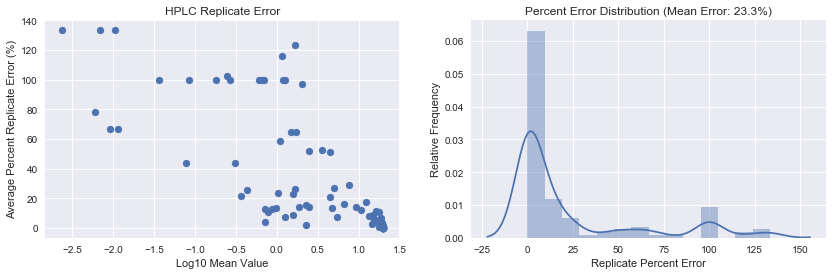

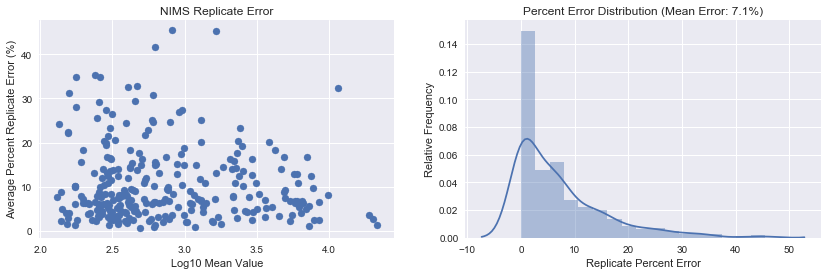

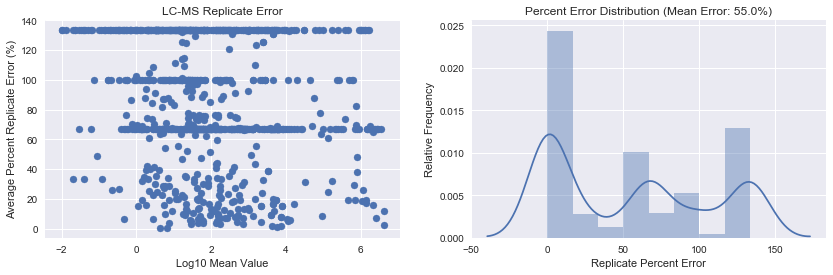

In [17]:
measurements = ['Targeted Proteomics','GC-MS','HPLC','NIMS','LC-MS']
logs = [True,True,True,True,True,True]
for measurement,log in zip(measurements,logs):
    analyze_replicate_error(df.columns.get_level_values(0)==measurement,log=log)
    plt.title('{} Replicate Error'.format(measurement))
    plt.xlabel('Log10 Mean Value')
    plt.ylabel('Average Percent Replicate Error (%)')
    #if ~log:
    #    plt.xlim(left=0)
    #    plt.ylim(bottom=0)
    plt.show()

tolerances = [30,30,40,40,40]
for measurement,tolerance in zip(measurements,tolerances):
    display_high_error_measurements(df.columns.get_level_values(0)==measurement,tolerance,file='tmp/{}.txt'.format(measurement))

### Relationship between NIMS technical replicate error and biological replicate error.  

See if we can determine relationships in the highest biological error samples and see if it holds across assay modalities.

### Batch to Batch Variation Analysis

We analyze the batch to batch variation between measurements.

In [18]:
#Calculate Batch To Batch Percent Variation For Each Measurement Using Strain 9017!
groups = df.groupby([('Metadata','Batch'),('Metadata','Tak')])
batch_means = []
for group in groups:
    if group[0][1] == 9017.0:
        batch_means.append(group[1].mean())

for i in range(len(batch_means)):
    batch_means[i] = batch_means[i].to_frame()
    
batch_df = pd.merge(batch_means[0],batch_means[1],how='left',left_index=True,right_index=True)
batch_df = pd.merge(batch_df,batch_means[2],how='left',left_index=True,right_index=True)
#display(batch_df)
#display(batch_df.mean(axis=1))

#Calculate Total Batch to Batch Percent Variation Across All Measurements
batch_percent_df = batch_df.apply(mean_percent_deviation,axis=1).to_frame()
batch_percent_df = pd.merge(batch_percent_df,batch_df.mean(axis=1).to_frame(),how='left',left_index=True,right_index=True)
batch_percent_df.columns = ['Percent Measurement Error','Mean Measurement Value']


#display(batch_percent_df.loc[batch_percent_df.index.get_level_values(0).isin(set(('Targeted Proteomics','HPLC','GC-MS','Metabolomics')))])

In [19]:
tak_groups = df.groupby([('Metadata','Tak')])

#Get List of Tak Numbers that are in multiple batches
multibatch_taks = []
for tak in tak_groups:
    if len(tak[1][('Metadata','Batch')].unique()) > 1:
        multibatch_taks.append(tak[0])
        
#Prune the df to only include taks in the multibatch set
measurement_protocols = ['Targeted Proteomics','GC-MS','HPLC','Metabolomics','Metadata','LC-MS'] 
multibatch_df = df.loc[df[('Metadata','Tak')].isin(multibatch_taks),df.columns.get_level_values(0).isin(measurement_protocols)]


# For Each Measurement:
# Calculate Individual Batch Replicate Error
# Calculate Between Batch Replicate Error
batch_error_df = None
multibatch_groups = multibatch_df.groupby([('Metadata','Tak'),('Metadata','Batch')])
for multibatch_group in multibatch_groups:
    
    #Calculate Mean
    multibatch_group_df = multibatch_group[1].loc[:,~multibatch_group[1].columns.get_level_values(0).isin(['Metadata']) ]
    #display(temp_df)
    temp_df = multibatch_group_df.mean().to_frame()
    temp_df.columns = pd.MultiIndex.from_tuples([('Strain {}'.format(int(multibatch_group[0][0])),'Batch {} Mean'.format(int(multibatch_group[0][1])))])
    
    #Calculate Percent Error
    temp_percent_df = multibatch_group_df.apply(mean_percent_deviation).to_frame()
    temp_percent_df.columns = pd.MultiIndex.from_tuples([('Strain {}'.format(int(multibatch_group[0][0])),'Batch {} Percent Error'.format(int(multibatch_group[0][1])))])
    temp_df = pd.merge(temp_df,temp_percent_df,how='left',left_index=True,right_index=True)
    
    
    if batch_error_df is None:
        batch_error_df = temp_df
    else:
        batch_error_df = pd.merge(batch_error_df,temp_df,how='left',left_index=True,right_index=True)

#Perform Aggrigate Batch Statistics on Group
for strain in batch_error_df.columns.get_level_values(0).unique():
    #Get mean values and calculate aggrigate mean and percent error
    strain_columns = batch_error_df.columns.get_level_values(0)==strain
    mean_columns =  ['Mean' in col for col in batch_error_df.columns.get_level_values(1)]
    
    batch_error_df[(strain,'Aggrigate Mean')] = batch_error_df.loc[:,strain_columns & mean_columns].mean(axis=1).to_frame()
    batch_error_df[(strain,'Aggrigate Percent Error')] = batch_error_df.loc[:,strain_columns & mean_columns].apply(mean_percent_deviation,axis=1)
    
    print(strain)
    display(batch_error_df[strain])

Strain 1


Batch 1 Mean  \
Protocol Name       Measurement Type                                                    
Targeted Proteomics A1U2T0_MARHV                                             0.000000   
                    A1U3L3_MARHV                                        166154.500000   
                    ACR1_ACIAD                                               0.000000   
                    AHR_ECOLI                                                0.000000   
                    FATB_UMBCA                                          143548.500000   
                    LCFA_ECOLI                                          110444.500000   
GC-MS               Dodecanoate (n-C12:0)                                    0.689090   
                    Hexadecanoate (n-C16:0)                                  0.026210   
                    Octadecanoate (n-C18:0)                                  0.070450   
                    Tetradecanoate (n-C14:0)                                 0.056840   
HPLC                Acetate                                                  0.085130   
                    D-Glucose                                                0.000000   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                            0.000000   
                    3-Phospho-D-glycerate                                    0.000000   
                    ADP                                                      0.000000   
                    AMP                                                      0.000000   
                    ATP                                                      0.000000   
                    Acetyl-CoA                                               0.000000   
                    Citrate                                                  0.000000   
                    D-Fructose 1,6-bisphosphate                              0.000000   
                    D-Fructose 6-phosphate                                   0.000000   
                    D-Glucose 6-phosphate                                    0.000000   
                    Dihydroxyacetone phosphate                               0.000000   
                    Dodecanoyl-CoA (n-C12:0CoA)                              0.000000   
                    Flavin adenine dinucleotide oxidized                     0.000000   
                    Glyceraldehyde 3-phosphate                               0.000000   
                    Isocitrate                                               0.000000   
                    L-Malate                                                 0.000000   
                    Nicotinamide adenine dinucleotide                        0.000000   
                    Nicotinamide adenine dinucleotide - reduced              0.000000   
                    Nicotinamide adenine dinucleotide phosphate              0.000000   
                    Nicotinamide adenine dinucleotide phosphate - r...       0.000000   
                    Oxaloacetate                                             0.000000   
                    Phosphoenolpyruvate                                      0.000000   
                    Pyruvate                                                 0.000000   
                    Stearoyl-CoA (n-C18:0CoA)                                0.000000   
                    Succinate                                                0.000000   
                    Tetradecanoyl-CoA (n-C14:0CoA)                           0.000000   
GC-MS               Total Fatty Alcohols                                     0.842590   
Targeted Proteomics Total Protein                                       421110.000000   
HPLC                Glucose Consumed                                        20.000000   
GC-MS               Dodecanoate Yeild                                        0.034454   
LC-MS               Decanoic acid                                            0.000000   
                    Lauric acid                                     

Strain 2


Batch 1 Mean  \
Protocol Name       Measurement Type                                                    
Targeted Proteomics A1U2T0_MARHV                                             0.000000   
                    A1U3L3_MARHV                                        156814.500000   
                    ACR1_ACIAD                                               0.000000   
                    AHR_ECOLI                                                0.000000   
                    FATB_UMBCA                                          142764.000000   
                    LCFA_ECOLI                                          108696.000000   
GC-MS               Dodecanoate (n-C12:0)                                    0.568620   
                    Hexadecanoate (n-C16:0)                                  0.031090   
                    Octadecanoate (n-C18:0)                                  0.067370   
                    Tetradecanoate (n-C14:0)                                 0.050775   
HPLC                Acetate                                                  0.608245   
                    D-Glucose                                                0.687720   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                            0.000000   
                    3-Phospho-D-glycerate                                  278.980000   
                    ADP                                                      0.000000   
                    AMP                                                    753.560000   
                    ATP                                                    132.445000   
                    Acetyl-CoA                                          778614.840250   
                    Citrate                                                 35.210000   
                    D-Fructose 1,6-bisphosphate                             31.250000   
                    D-Fructose 6-phosphate                                   0.000000   
                    D-Glucose 6-phosphate                                    7.040000   
                    Dihydroxyacetone phosphate                              21.695000   
                    Dodecanoyl-CoA (n-C12:0CoA)                          87916.651590   
                    Flavin adenine dinucleotide oxidized                  4512.125000   
                    Glyceraldehyde 3-phosphate                               0.000000   
                    Isocitrate                                              21.885000   
                    L-Malate                                                 2.680000   
                    Nicotinamide adenine dinucleotide                     4512.125000   
                    Nicotinamide adenine dinucleotide - reduced             24.075000   
                    Nicotinamide adenine dinucleotide phosphate              0.000000   
                    Nicotinamide adenine dinucleotide phosphate - r...       0.000000   
                    Oxaloacetate                                             0.000000   
                    Phosphoenolpyruvate                                     11.120000   
                    Pyruvate                                                 0.000000   
                    Stearoyl-CoA (n-C18:0CoA)                                0.000000   
                    Succinate                                                0.000000   
                    Tetradecanoyl-CoA (n-C14:0CoA)                           0.000000   
GC-MS               Total Fatty Alcohols                                     0.717855   
Targeted Proteomics Total Protein                                       409844.500000   
HPLC                Glucose Consumed                                        19.312280   
GC-MS               Dodecanoate Yeild                                        0.029285   
LC-MS               Decanoic acid                                           13.435000   
                    Lauric acid                                     

Strain 8


Batch 1 Mean  \
Protocol Name       Measurement Type                                                    
Targeted Proteomics A1U2T0_MARHV                                             0.000000   
                    A1U3L3_MARHV                                        203614.000000   
                    ACR1_ACIAD                                               0.000000   
                    AHR_ECOLI                                                0.000000   
                    FATB_UMBCA                                          110641.000000   
                    LCFA_ECOLI                                          167796.500000   
GC-MS               Dodecanoate (n-C12:0)                                    0.779450   
                    Hexadecanoate (n-C16:0)                                  0.019575   
                    Octadecanoate (n-C18:0)                                  0.073300   
                    Tetradecanoate (n-C14:0)                                 0.068120   
HPLC                Acetate                                                  0.000000   
                    D-Glucose                                                0.000000   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                            0.000000   
                    3-Phospho-D-glycerate                                  141.510000   
                    ADP                                                      0.000000   
                    AMP                                                    258.365000   
                    ATP                                                     36.290000   
                    Acetyl-CoA                                          226964.624200   
                    Citrate                                                 35.615000   
                    D-Fructose 1,6-bisphosphate                              5.220000   
                    D-Fructose 6-phosphate                                   0.000000   
                    D-Glucose 6-phosphate                                    1.675000   
                    Dihydroxyacetone phosphate                               0.880000   
                    Dodecanoyl-CoA (n-C12:0CoA)                          19347.084440   
                    Flavin adenine dinucleotide oxidized                  2738.670000   
                    Glyceraldehyde 3-phosphate                               0.000000   
                    Isocitrate                                               0.000000   
                    L-Malate                                                 0.560000   
                    Nicotinamide adenine dinucleotide                     2738.672000   
                    Nicotinamide adenine dinucleotide - reduced             24.850000   
                    Nicotinamide adenine dinucleotide phosphate            220.750000   
                    Nicotinamide adenine dinucleotide phosphate - r...       0.000000   
                    Oxaloacetate                                             0.000000   
                    Phosphoenolpyruvate                                      2.175000   
                    Pyruvate                                                 0.000000   
                    Stearoyl-CoA (n-C18:0CoA)                                0.000000   
                    Succinate                                                0.000000   
                    Tetradecanoyl-CoA (n-C14:0CoA)                           0.000000   
GC-MS               Total Fatty Alcohols                                     0.940445   
Targeted Proteomics Total Protein                                       482051.500000   
HPLC                Glucose Consumed                                        20.000000   
GC-MS               Dodecanoate Yeild                                        0.038972   
LC-MS               Decanoic acid                                            0.000000   
                    Lauric acid                                     

Strain 11


Batch 1 Mean  \
Protocol Name       Measurement Type                                                    
Targeted Proteomics A1U2T0_MARHV                                             0.000000   
                    A1U3L3_MARHV                                        711228.500000   
                    ACR1_ACIAD                                               0.000000   
                    AHR_ECOLI                                                0.000000   
                    FATB_UMBCA                                           74851.500000   
                    LCFA_ECOLI                                          129434.500000   
GC-MS               Dodecanoate (n-C12:0)                                    0.536025   
                    Hexadecanoate (n-C16:0)                                  0.035180   
                    Octadecanoate (n-C18:0)                                  0.083915   
                    Tetradecanoate (n-C14:0)                                 0.057755   
HPLC                Acetate                                                  0.726885   
                    D-Glucose                                                2.302625   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                            0.000000   
                    3-Phospho-D-glycerate                                  171.745000   
                    ADP                                                      0.000000   
                    AMP                                                   2047.730000   
                    ATP                                                     69.320000   
                    Acetyl-CoA                                          476827.025500   
                    Citrate                                                 30.620000   
                    D-Fructose 1,6-bisphosphate                             19.520000   
                    D-Fructose 6-phosphate                                   0.000000   
                    D-Glucose 6-phosphate                                    5.790000   
                    Dihydroxyacetone phosphate                               2.730000   
                    Dodecanoyl-CoA (n-C12:0CoA)                              0.000000   
                    Flavin adenine dinucleotide oxidized                     0.000000   
                    Glyceraldehyde 3-phosphate                               0.000000   
                    Isocitrate                                               0.000000   
                    L-Malate                                                 0.550000   
                    Nicotinamide adenine dinucleotide                        0.000000   
                    Nicotinamide adenine dinucleotide - reduced             30.845000   
                    Nicotinamide adenine dinucleotide phosphate            314.630000   
                    Nicotinamide adenine dinucleotide phosphate - r...       0.000000   
                    Oxaloacetate                                             0.000000   
                    Phosphoenolpyruvate                                      6.235000   
                    Pyruvate                                                 0.175000   
                    Stearoyl-CoA (n-C18:0CoA)                                0.000000   
                    Succinate                                                0.000000   
                    Tetradecanoyl-CoA (n-C14:0CoA)                           0.000000   
GC-MS               Total Fatty Alcohols                                     0.712875   
Targeted Proteomics Total Protein                                       915704.500000   
HPLC                Glucose Consumed                                        17.697375   
GC-MS               Dodecanoate Yeild                                        0.030289   
LC-MS               Decanoic acid                                            0.000000   
                    Lauric acid                                     

Strain 16


Batch 1 Mean  \
Protocol Name       Measurement Type                                                    
Targeted Proteomics A1U2T0_MARHV                                         15022.500000   
                    A1U3L3_MARHV                                             0.000000   
                    ACR1_ACIAD                                               0.000000   
                    AHR_ECOLI                                                0.000000   
                    FATB_UMBCA                                           89349.500000   
                    LCFA_ECOLI                                           99953.500000   
GC-MS               Dodecanoate (n-C12:0)                                    0.000000   
                    Hexadecanoate (n-C16:0)                                  0.071160   
                    Octadecanoate (n-C18:0)                                  0.171105   
                    Tetradecanoate (n-C14:0)                                 0.002685   
HPLC                Acetate                                                  2.492945   
                    D-Glucose                                                1.255300   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                            0.000000   
                    3-Phospho-D-glycerate                                   41.000000   
                    ADP                                                      0.000000   
                    AMP                                                   4648.405000   
                    ATP                                                     90.695000   
                    Acetyl-CoA                                          267522.391750   
                    Citrate                                                 25.480000   
                    D-Fructose 1,6-bisphosphate                              2.755000   
                    D-Fructose 6-phosphate                                   0.000000   
                    D-Glucose 6-phosphate                                    0.505000   
                    Dihydroxyacetone phosphate                               0.175000   
                    Dodecanoyl-CoA (n-C12:0CoA)                          11398.375930   
                    Flavin adenine dinucleotide oxidized                     0.000000   
                    Glyceraldehyde 3-phosphate                               0.000000   
                    Isocitrate                                               0.000000   
                    L-Malate                                                 0.910000   
                    Nicotinamide adenine dinucleotide                        0.000000   
                    Nicotinamide adenine dinucleotide - reduced              9.885000   
                    Nicotinamide adenine dinucleotide phosphate            317.915000   
                    Nicotinamide adenine dinucleotide phosphate - r...       0.000000   
                    Oxaloacetate                                             0.000000   
                    Phosphoenolpyruvate                                      1.385000   
                    Pyruvate                                                 0.075000   
                    Stearoyl-CoA (n-C18:0CoA)                                0.000000   
                    Succinate                                                0.000000   
                    Tetradecanoyl-CoA (n-C14:0CoA)                           0.000000   
GC-MS               Total Fatty Alcohols                                     0.244950   
Targeted Proteomics Total Protein                                       205678.500000   
HPLC                Glucose Consumed                                        18.744700   
GC-MS               Dodecanoate Yeild                                        0.000000   
LC-MS               Decanoic acid                                           54.105000   
                    Lauric acid                                     

Strain 9017


Batch 1 Mean  \
Protocol Name       Measurement Type                                                   
Targeted Proteomics A1U2T0_MARHV                                        2.354650e+04   
                    A1U3L3_MARHV                                        0.000000e+00   
                    ACR1_ACIAD                                          0.000000e+00   
                    AHR_ECOLI                                           1.726000e+03   
                    FATB_UMBCA                                          0.000000e+00   
                    LCFA_ECOLI                                          5.135000e+02   
GC-MS               Dodecanoate (n-C12:0)                               0.000000e+00   
                    Hexadecanoate (n-C16:0)                             6.243600e-01   
                    Octadecanoate (n-C18:0)                             3.629750e-01   
                    Tetradecanoate (n-C14:0)                            3.722950e-01   
HPLC                Acetate                                             9.701600e-01   
                    D-Glucose                                           7.594970e+00   
LC-MS               (S)-3-Hydroxyhexadecanoyl-CoA                       0.000000e+00   
                    3-Phospho-D-glycerate                               1.569200e+02   
                    ADP                                                 0.000000e+00   
                    AMP                                                 4.388755e+03   
                    ATP                                                 4.205000e+02   
                    Acetyl-CoA                                          2.146041e+06   
                    Citrate                                             4.437000e+01   
                    D-Fructose 1,6-bisphosphate                         1.251050e+02   
                    D-Fructose 6-phosphate                              0.000000e+00   
                    D-Glucose 6-phosphate                               1.056000e+01   
                    Dihydroxyacetone phosphate                          3.095000e+00   
                    Dodecanoyl-CoA (n-C12:0CoA)                         0.000000e+00   
                    Flavin adenine dinucleotide oxidized                0.000000e+00   
                    Glyceraldehyde 3-phosphate                          0.000000e+00   
                    Isocitrate                                          1.715900e+02   
                    L-Malate                                            4.350000e+00   
                    Nicotinamide adenine dinucleotide                   0.000000e+00   
                    Nicotinamide adenine dinucleotide - reduced         0.000000e+00   
                    Nicotinamide adenine dinucleotide phosphate         1.472150e+02   
                    Nicotinamide adenine dinucleotide phosphate - r...  0.000000e+00   
                    Oxaloacetate                                        0.000000e+00   
                    Phosphoenolpyruvate                                 6.620000e+00   
                    Pyruvate                                            4.600000e-01   
                    Stearoyl-CoA (n-C18:0CoA)                           0.000000e+00   
                    Succinate                                           0.000000e+00   
                    Tetradecanoyl-CoA (n-C14:0CoA)                      0.000000e+00   
GC-MS               Total Fatty Alcohols                                1.359630e+00   
Targeted Proteomics Total Protein                                       2.578600e+04   
HPLC                Glucose Consumed                                    1.240503e+01   
GC-MS               Dodecanoate Yeild                                   0.000000e+00   
LC-MS               Decanoic acid                                       0.000000e+00   
                    Lauric acid                                         8.060000e+00   
                    Myri

In [20]:
#Plot Biological Replicates

#for strain in df_columns.get_level_values(0):
#    pass
    #Get Aggrigate Means and linearize
    
    #Get Aggrigate Percent Errors and Linearize
    
    #Plot Distribution of Percent Error
    
    #Plot Means vs Percent Errors
df.to_csv('tmp/uncleaned_data.csv')

#### Set to NaN any measurement that has greater than 50% Error

Attempt to clean up the data some by dropping measurments with poor agreement. 

In [21]:
#Set Inclusion Threshold for Data
threshold = 50.0 #Percent Replicate Error Allowed

#Get all Replicate Pairs
columns = df.columns.get_level_values(0) != 'Metadata'
for group in df.groupby([('Metadata','Batch'),('Metadata','Tak')]):
    replicate_df = group[1].iloc[:, columns]
    
    #Check Measurment Accuacy Per Column
    percent_df = replicate_df.fillna(0).apply(mean_percent_deviation,axis=0)
    
    #If its greater than the threshold (50%) Make the Measurement a NaN
    nan_cols = list(percent_df.loc[abs(percent_df) > threshold].index)
    nan_rows = list(replicate_df.index)
    
    df.loc[df.index.isin(nan_rows),df.columns.isin(nan_cols)] = float('NaN')

/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10


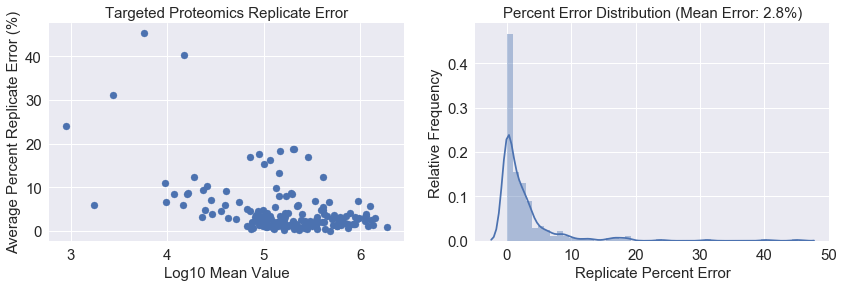

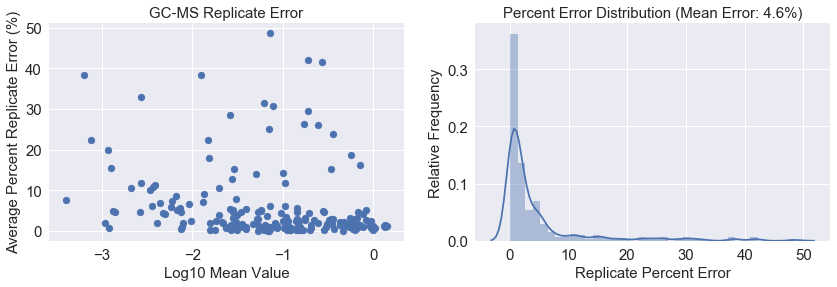

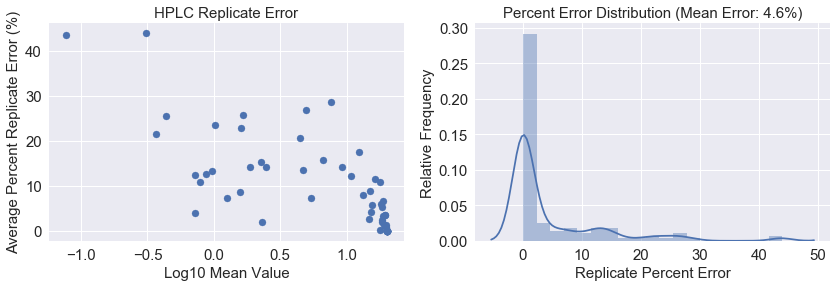

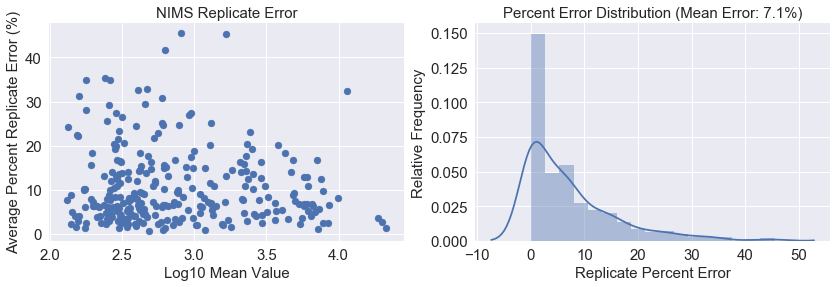

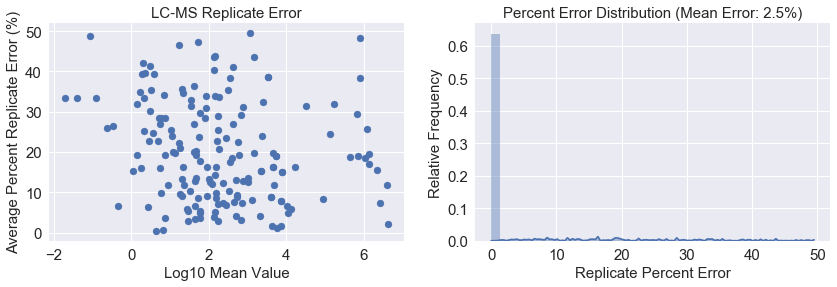

In [22]:
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

import matplotlib.pylab as pylab
params = {
         'axes.labelsize': 15,
         'axes.titlesize':15,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)


measurements = ['Targeted Proteomics','GC-MS','HPLC','NIMS','LC-MS']
logs = [True,True,True,True,True,True]
for measurement,log in zip(measurements,logs):
    analyze_replicate_error(df.columns.get_level_values(0)==measurement,log=log)
    plt.title('{} Replicate Error'.format(measurement))
    plt.xlabel('Log10 Mean Value')
    plt.ylabel('Average Percent Replicate Error (%)')
    #if ~log:
    #    plt.xlim(left=0)
    #    plt.ylim(bottom=0)
    plt.show()

tolerances = [30,30,40,40,40]
for measurement,tolerance in zip(measurements,tolerances):
    display_high_error_measurements(df.columns.get_level_values(0)==measurement,tolerance,file='{}.txt'.format(measurement))

#### Remove Control Strains from Dataframes for downstream processing

We don't want the control strains to be used for correlations in downstream processing

In [23]:
#Remove Tak Number 9017 & RFP strains from data!
df = df.loc[~df[('Metadata','Tak')].isin([9017.0,float('NaN')])]
display(df)
df.to_csv('tmp/cleaned_data.csv')

Protocol Name    Targeted Proteomics                                    \
Measurement Type        A1U2T0_MARHV A1U3L3_MARHV ACR1_ACIAD AHR_ECOLI   
Line Name                                                                
b1-01-1                          0.0     159144.0        0.0       0.0   
b1-01-2                          0.0     173165.0        0.0       0.0   
b1-02-1                          0.0     158408.0        0.0       0.0   
b1-02-2                          0.0     155221.0        0.0       0.0   
b1-04-1                          0.0     565758.0        0.0       0.0   
b1-04-2                          0.0     579082.0        0.0       0.0   
b1-08-1                          0.0     202718.0        0.0       0.0   
b1-08-2                          0.0     204510.0        0.0       0.0   
b1-09-1                          0.0     207289.0        0.0       0.0   
b1-09-2                          0.0     232565.0        0.0       0.0   
b1-11-1                          0.0     686451.0        0.0       0.0   
b1-11-2                          0.0     736006.0        0.0       0.0   
b1-12-1                          0.0     740579.0        0.0       0.0   
b1-12-2                          0.0     762921.0        0.0       0.0   
b1-15-1                       8372.0          0.0        0.0       0.0   
b1-15-2                      10438.0          0.0        0.0       0.0   
b1-16-1                      21091.0          0.0        0.0       0.0   
b1-16-2                       8954.0          0.0        0.0       0.0   
b1-22-1                          0.0          0.0    44506.0  184852.0   
b1-22-2                          0.0          0.0    37032.0  170458.0   
b2-11-1                          0.0     360114.0        0.0       0.0   
b2-11-2                          0.0     405148.0        0.0       0.0   
b2-11-3                          0.0     400045.0        0.0       0.0   
b2-19-1                     192296.0          0.0        0.0       0.0   
b2-19-2                     171189.0          0.0        0.0       0.0   
b2-19-3                     151364.0          0.0        0.0       0.0   
b2-25-1                          0.0          0.0     8806.0  101260.0   
b2-25-2                          0.0          0.0    10664.0  109298.0   
b2-25-3                          0.0          0.0     9914.0  101216.0   
b2-26-1                          0.0          0.0    16566.0  109625.0   
...                              ...          ...        ...       ...   
b3-06-1                          0.0     215241.0        0.0       0.0   
b3-06-2                          0.0     217714.0        0.0       0.0   
b3-06-3                          0.0     247382.0        0.0       0.0   
b3-07-1                          0.0      99544.0        0.0       0.0   
b3-07-2                          0.0      96436.0        0.0       0.0   
b3-07-3                          0.0     105513.0        0.0       0.0   
b3-08-1                          0.0      87508.0        0.0       0.0   
b3-08-2                          0.0      87744.0        0.0       0.0   
b3-08-3                          0.0      82715.0        0.0       0.0   
b3-10-1                          0.0     499232.0        0.0       0.0   
b3-10-2                          0.0     532764.0        0.0       0.0   
b3-10-3                          0.0     503145.0        0.0       0.0   
b3-13-1                      12448.0          0.0        0.0       0.0   
b3-13-2                      12835.0          0.0        0.0       0.0   
b3-13-3                      10366.0          0.0        0.0       0.0   
b3-16-1                       4053.0          0.0        0.0       0.0   
b3-16-2                       3475.0          0.0        0.0       0.0   
b3-16-3                       9574.0          0.0        0.0       0.0   
b3-18-1                     215377.0          0.0        0.0       0.0   
b3-18-2                     203658.0          0.0        0.0       0.0   
b3-1

In [24]:
print(217714.0/7.79e4)
print(217714.0/2.15e3)

print(df['Metadata'].columns)
display(df['Metadata'].loc[df[('Metadata','Tak')]==32])
#display(df[[('Targeted Proteomics','LCFA_ECOLI'),('Metadata','FadD'),('TIR','FadD')]])
display(df[[('Targeted Proteomics','LCFA_ECOLI'),('Metadata','FadD'),('TIR','FadD')]].loc[df[('Metadata','Tak')]==32])
display(df[[('Targeted Proteomics','LCFA_ECOLI'),('Metadata','FadD'),('TIR','FadD')]].loc[df[('Metadata','Tak')]==33])

#display(df['Targeted Proteomics'].loc[df[('Targeted Proteomics','Tak')]==11])
#display(df['Metadata'].loc[df[('Metadata','Tak')]==11])
#display(df['TIR'].loc[df[('Metadata','Tak')]==11])
#display(df['Targeted Proteomics'].loc[df[('Metadata','Tak')]==5])
#selector = np.logical_and(df[('Metadata','FadD')]=='M' , df[('Metadata','Tak') == 5])
#display(df['Targeted Proteomics'].loc[df[('Metadata','Tak')] == 5])

2.794788189987163
101.26232558139534
Index(['Strain', 'Batch', 'Tak', 'Replicate', 'UcFatB1', 'FadD', 'Maqu_2507',
       'Maqu_2220', 'acr1', 'yjgB', 'Pathway Variant'],
      dtype='object', name='Measurement Type')


Measurement Type      Strain  Batch   Tak  Replicate UcFatB1 FadD Maqu_2507  \
Line Name                                                                     
b2-32-1           JBEI-17826    2.0  32.0        1.0       M    L       NaN   
b2-32-2           JBEI-17826    2.0  32.0        2.0       M    L       NaN   
b2-32-3           JBEI-17826    2.0  32.0        3.0       M    L       NaN   

Measurement Type Maqu_2220 acr1 yjgB  Pathway Variant  
Line Name                                              
b2-32-1                  H  NaN  NaN              2.0  
b2-32-2                  H  NaN  NaN              2.0  
b2-32-3                  H  NaN  NaN              2.0

Protocol Name    Targeted Proteomics Metadata  TIR
Measurement Type          LCFA_ECOLI     FadD FadD
Line Name                                         
b2-32-1                     223440.0        L  752
b2-32-2                     212751.0        L  752
b2-32-3                     217714.0        L  752

Protocol Name    Targeted Proteomics Metadata   TIR
Measurement Type          LCFA_ECOLI     FadD  FadD
Line Name                                          
b2-33-1                     180662.0        M  1913
b2-33-2                     176053.0        M  1913
b2-33-3                     176585.0        M  1913

#### Combine Replicates

If Quality Control Passes Combine all replicates and calculate mean and standard deviation

In [25]:
#Calculate Mean Measurements for each strain
measurement_types = ['Targeted Proteomics','GC-MS','HPLC','Metabolomics','TIR','NIMS']
mean_df = df.groupby([('Metadata','Tak')]).mean()
mean_df = mean_df.loc[:,mean_df.columns.get_level_values(0).isin(measurement_types)]
#display(mean_df)

## 1.2 Cycle 1 Feature Analysis

We use covariance analysis and information theoretic measures to analyze univariate relationships between features and make reccomendations for features where increasing the variance might be helpful.

In [26]:
log_proteomics = False
if log_proteomics:
    zero = np.vectorize(lambda x: 1 if x == 0 else x)
    log = np.vectorize(np.log)
    display(df['Targeted Proteomics'])
    df['Targeted Proteomics'] = log(zero(df['Targeted Proteomics']))
    display(df['Targeted Proteomics'])

#### Overview Heatmap for Cycle 1
Below is a heatmap of all of the strains created in cycle 1 and their production data. 

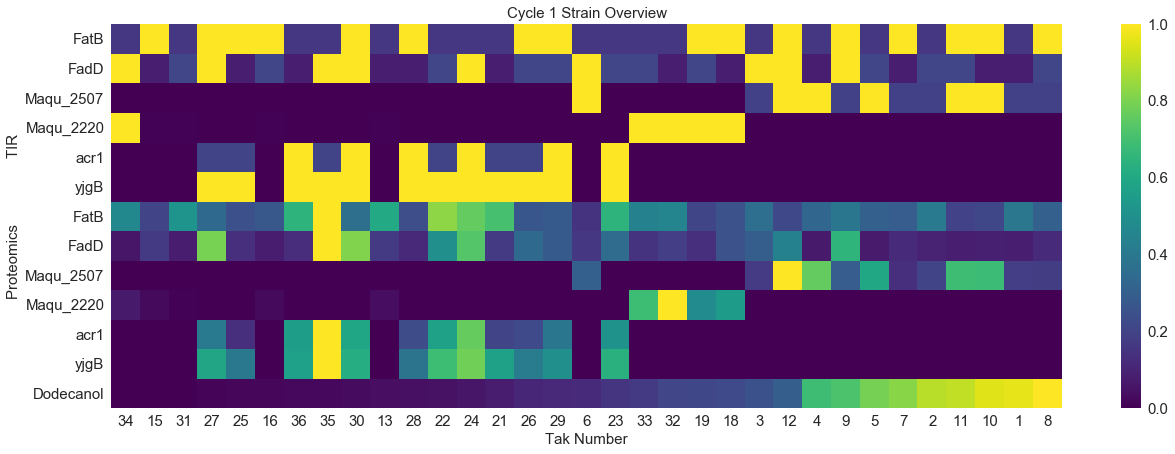

In [27]:
%matplotlib inline
plt.figure(figsize=(18,6))

#print(list(mean_df.columns))
#display(mean_df)

col_norm = lambda col: col/max(col)

#Create Matrix of all catagories for the heatmap and Normalize by Column with a maximum at 1 and a min at 0
columns = [('TIR', 'UcFatB1'), ('TIR', 'FadD'), ('TIR', 'Maqu_2507'), ('TIR', 'Maqu_2220'), ('TIR', 'acr1'),('TIR','yjgB'),
           ('Targeted Proteomics', 'FATB_UMBCA'),('Targeted Proteomics', 'LCFA_ECOLI'),('Targeted Proteomics', 'A1U3L3_MARHV'),('Targeted Proteomics', 'A1U2T0_MARHV'),  ('Targeted Proteomics', 'ACR1_ACIAD'), ('Targeted Proteomics', 'AHR_ECOLI'),
           ('GC-MS', 'Dodecanoate (n-C12:0)')]

normal_df = mean_df[columns].apply(col_norm,axis=0).sort_values(('GC-MS', 'Dodecanoate (n-C12:0)'))
sns.heatmap(np.transpose(normal_df.values),cmap="viridis")

#Set Ticks
x_ticks = normal_df.index.values.astype(int)
y_ticks = ['FatB','FadD','Maqu_2507','Maqu_2220','acr1','yjgB','FatB','FadD','Maqu_2507','Maqu_2220','acr1','yjgB','Dodecanol']
y_ticks.reverse()
#print(y_ticks)

ax = plt.gca()
plt.yticks(rotation=0)
ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)

#Format Plot
plt.tight_layout()
plt.title('Cycle 1 Strain Overview')
plt.xlabel('Tak Number')
plt.ylabel('Proteomics                TIR')
plt.show()

#### Total Fatty Alcohol Production Of All Strains Plotted
We look at univariate distributions for total fatty alcohols and C12 fatty alcohol production for all non control strains.  Additionally, we examine the relationship between the two variables in graphical form. 

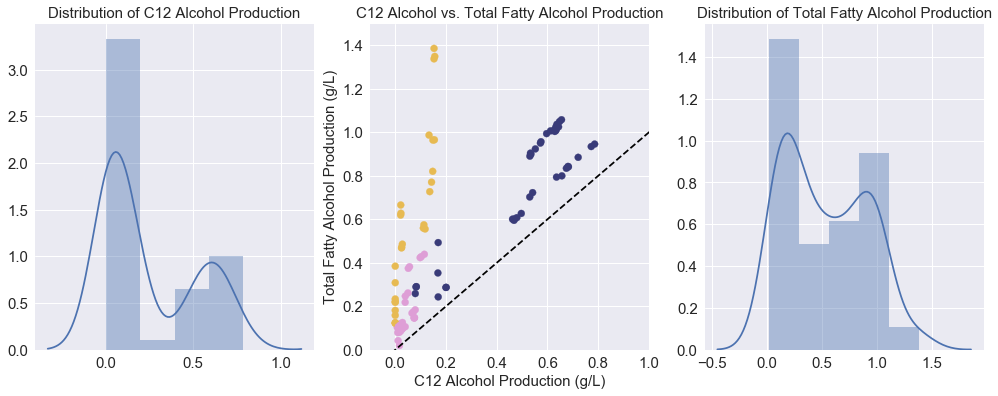

In [28]:
#Plot Total Fatty Alcohol Production & Hexadecanol Production Histograms

temp_df = df[[('GC-MS','Dodecanoate (n-C12:0)'),('GC-MS','Total Fatty Alcohols'),('Metadata','Pathway Variant')]].dropna()
c12_alcohols = temp_df[('GC-MS','Dodecanoate (n-C12:0)')].values
total_alcohols = temp_df[('GC-MS','Total Fatty Alcohols')].values


c12_alcohols_ave = mean_df[('GC-MS','Dodecanoate (n-C12:0)')].dropna().values
total_alcohols_ave = mean_df[('GC-MS','Total Fatty Alcohols')].values

plt.figure(figsize=(17,6))
plt.subplot(1,3,1)
sns.distplot(c12_alcohols)
plt.title('Distribution of C12 Alcohol Production')

plt.subplot(1,3,3)
sns.distplot(total_alcohols)
plt.title('Distribution of Total Fatty Alcohol Production')


plt.subplot(1,3,2)
plt.plot((-0.1,2),(-0.1,2),'k--')
plt.scatter(c12_alcohols,total_alcohols,c=temp_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
plt.xlim(-0.1,1)
plt.ylim(0,1.5)
plt.xlabel('C12 Alcohol Production (g/L)')
plt.ylabel('Total Fatty Alcohol Production (g/L)')
plt.title('C12 Alcohol vs. Total Fatty Alcohol Production')
plt.show()

#display(temp_df[[('GC-MS','Total Fatty Alcohols'),('Metadata','Pathway Variant')]].sort_values(('GC-MS','Total Fatty Alcohols'),ascending=False))


**A Correlational Analysis between the two RBS Calculators**

Two different Methods were used to predict RBS expression. Below these are compared to see if they are reasonably correlated.

The R value is 0.278 and the P value is 0.382.


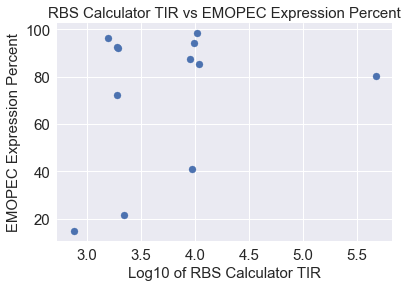

In [29]:
plt.scatter(np.log10(rbs_df['Predicted TIR']),rbs_df['EMOPEC'])
plt.title('RBS Calculator TIR vs EMOPEC Expression Percent')
plt.xlabel('Log10 of RBS Calculator TIR')
plt.ylabel('EMOPEC Expression Percent')
r_val,p_val = pearsonr(np.log10(rbs_df['Predicted TIR']),rbs_df['EMOPEC'])
print('The R value is {:.3f} and the P value is {:.3f}.'.format(r_val,p_val))
plt.show()

#### Bivariate Analysis Relating Individual Genes / Proteins to Production

In the below plot matrix the first column is Gene TIR Vs. Protein Counts.  Column 2 is Protein Area vs. C12 Fatty Alcohol.  Column 3 is Protein Area vs. Total Fatty Alcohol production.  Each Row corresponds to a different gene/protein in the pathway.  We can see which genes are correlated with production.

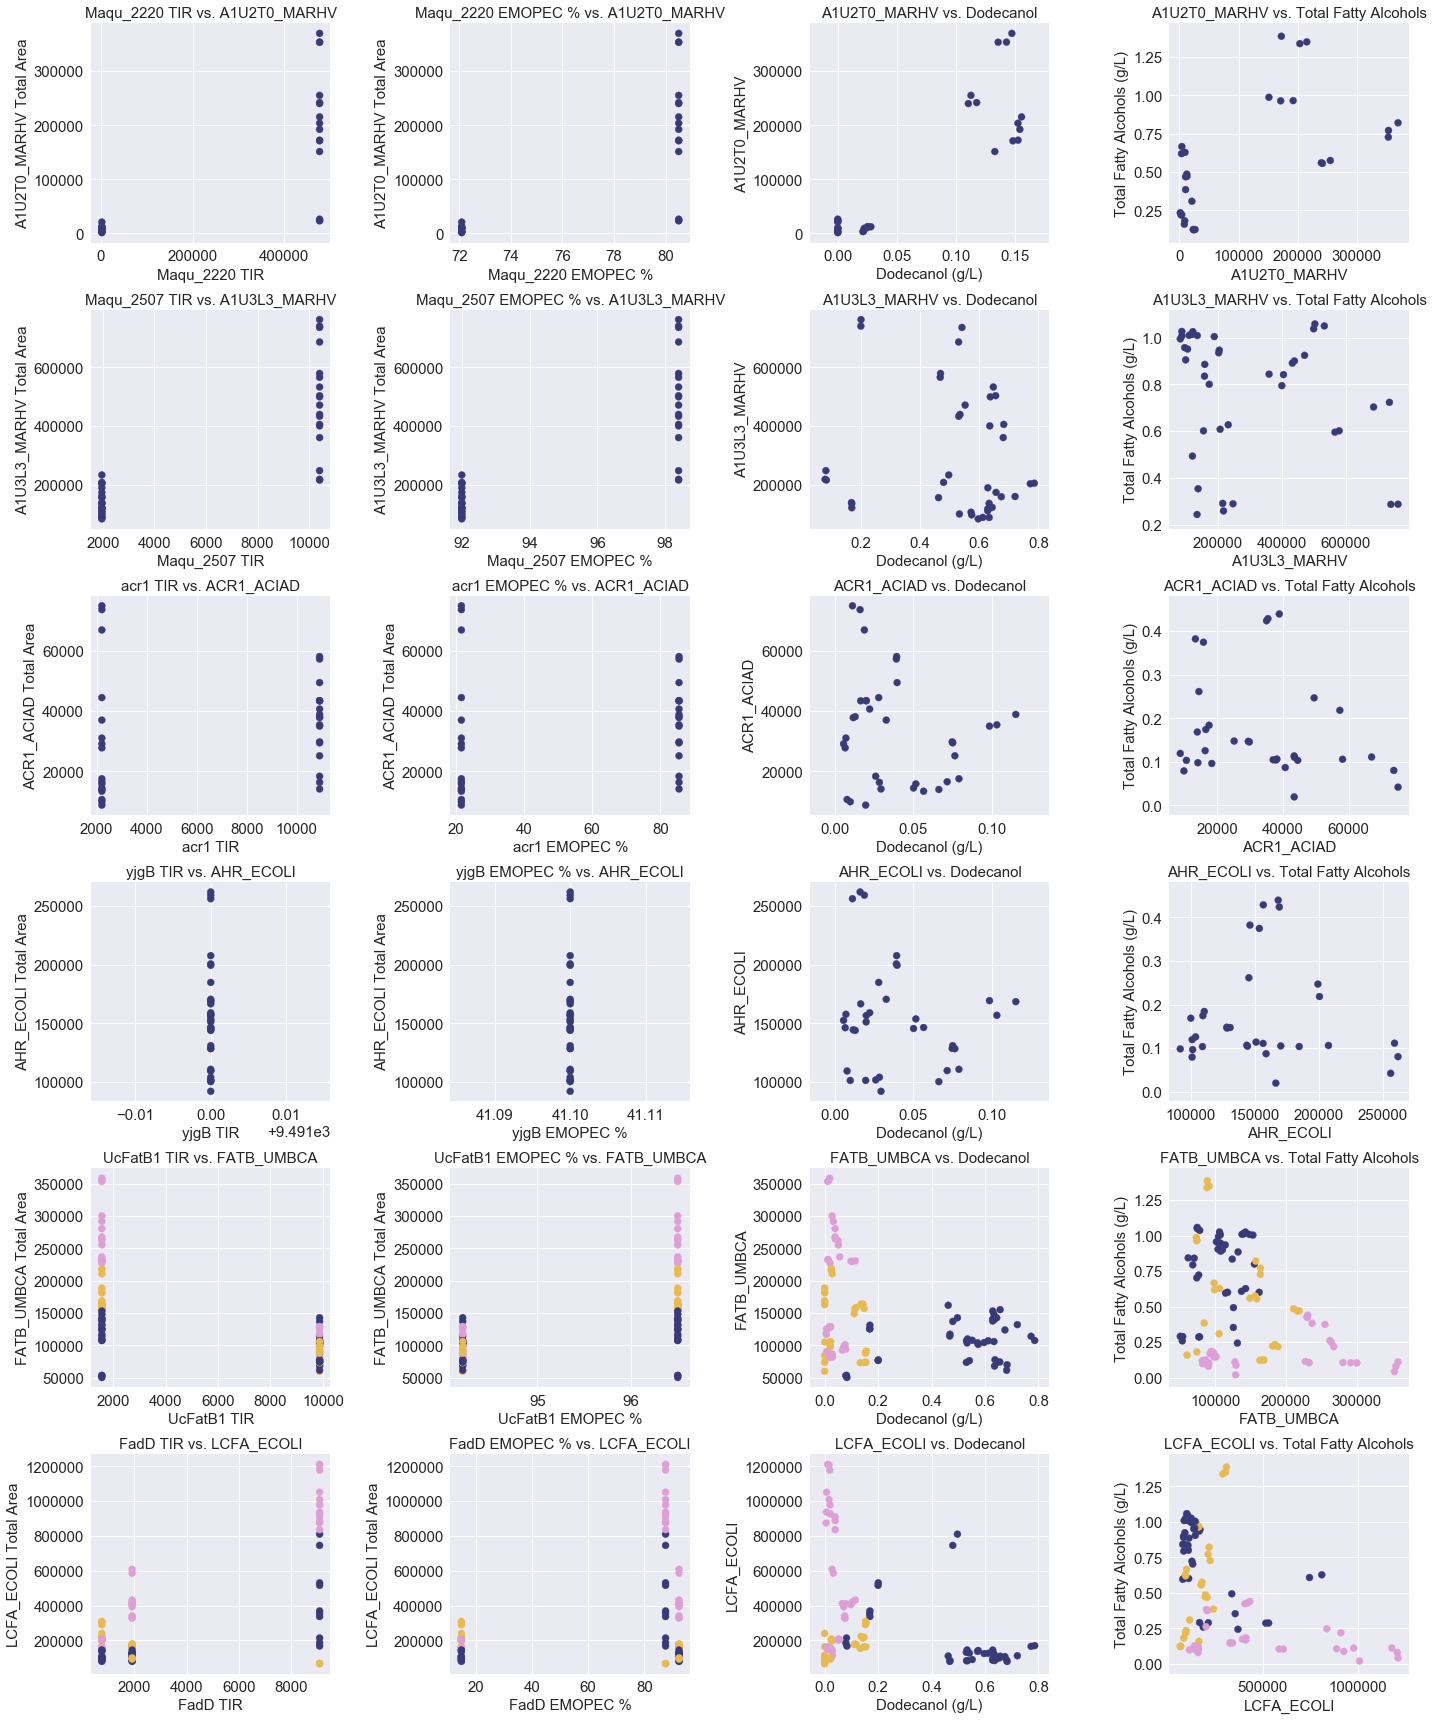

In [30]:
gene_protein_pairs = [
    ('Maqu_2220','A1U2T0_MARHV'),
    ('Maqu_2507','A1U3L3_MARHV'),
    ('acr1','ACR1_ACIAD'),
    ('yjgB','AHR_ECOLI'),
    ('UcFatB1','FATB_UMBCA'),
    ('FadD','LCFA_ECOLI')
]

pathway_specific_proteins = ['A1U2T0_MARHV','A1U3L3_MARHV','ACR1_ACIAD','AHR_ECOLI']
#display(df['Targeted Proteomics'])


i = 1
plt.figure(figsize=(20,6*4))
for gene,protein in gene_protein_pairs:
    
    #Select Pathway Specific Data
    if protein in pathway_specific_proteins:
        pathway_df = df.loc[df[('Targeted Proteomics',protein)]!= 0]
    else:
        pathway_df = df
    
    #Plot Univariate Relationships between TIRs & Proteins
    plt.subplot(6,4,i)
    #g = sns.regplot(x=pathway_df[('TIR',gene)], y=pathway_df[('Targeted Proteomics',protein)],ci=95,robust=False)
    plt.scatter(pathway_df[('TIR',gene)],pathway_df[('Targeted Proteomics',protein)],c=pathway_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
    plt.title('{} TIR vs. {}'.format(gene,protein))
    plt.xlabel('{} TIR'.format(gene))
    plt.ylabel('{} Total Area'.format(protein))
    
    #Plot Univariate Relationships Between Emopec Expression % and Proteins
    plt.subplot(6,4,i+1)
    plt.scatter(pathway_df[('EMOPEC',gene)],pathway_df[('Targeted Proteomics',protein)],c=pathway_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
    plt.title('{} EMOPEC % vs. {}'.format(gene,protein))
    plt.xlabel('{} EMOPEC %'.format(gene))
    plt.ylabel('{} Total Area'.format(protein))
    
    
    #Plot Univariate Relationships Between Proteins and Dodecanol
    plt.subplot(6,4,i+2)
    #g = sns.regplot(x=pathway_df[('Targeted Proteomics',protein)], y=pathway_df[('GC-MS','Dodecanoate (n-C12:0)')],ci=95,robust=False)
    plt.scatter(pathway_df[('GC-MS','Dodecanoate (n-C12:0)')],pathway_df[('Targeted Proteomics',protein)],c=pathway_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
    plt.title('{} vs. Dodecanol'.format(protein))
    plt.ylabel('{}'.format(protein))
    plt.xlabel('Dodecanol (g/L)')
    
    
    #Plot Relationship between Protein and 
    plt.subplot(6,4,i+3)
    #g = sns.regplot(x=pathway_df[('Targeted Proteomics',protein)], y=pathway_df[('GC-MS','Total Fatty Alcohols')],ci=95,robust=False)
    plt.scatter(pathway_df[('Targeted Proteomics',protein)],pathway_df[('GC-MS','Total Fatty Alcohols')],c=pathway_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
    plt.title('{} vs. Total Fatty Alcohols'.format(protein))
    plt.xlabel('{}'.format(protein))
    plt.ylabel('Total Fatty Alcohols (g/L)')
    
    i += 4
    
plt.tight_layout()
plt.show()

#### Bivariate Correlational Analysis
Correlational Analysis is Performed on all pairs of measured variables in the data.  143 Correlations were found to be statistically significant at the 95% confidence interval after adjustment for multiple correlations.  Tables of these correlations are displayed below.

In [31]:
# Calculate Covariance For All Variables then create a table and sort by correlation coefficient
measurement_headers = ['GC-MS','Targeted Proteomics','HPLC','NIMS','TIR','LC-MS']
#print(list(df.columns))
#Columns to drop zeros (always drop NaNs)
zero_drop_columns = ['TIR','Targeted Proteomics','NIMS']
correlation_df = df.loc[:,df.columns.get_level_values(0).isin(measurement_headers)]

total_comparisons = 0
data = []
for col1,col2 in itertools.combinations(correlation_df.columns, 2):
    if col1[0] in zero_drop_columns:
        rows1 = correlation_df[col1]!=0
    else:
        rows1 = np.array([True]*len(correlation_df[col1]))
    
    if col2[0] in zero_drop_columns:
        rows2 = correlation_df[col2]!=0
    else:
        rows2 = np.array([True]*len(correlation_df[col2]))
    
    nan_free_rows = ~np.isnan(correlation_df[col1]) & ~np.isnan(correlation_df[col2])

    
    temp_df = correlation_df.loc[rows1&rows2&nan_free_rows]
    #if (col1[1]=='Dodecanoate (n-C12:0)')|(col2[1]=='Dodecanoate (n-C12:0)'):
        #print(col1,col2)
        #print(rows2&rows1)
        #display(correlation_df[[col1,col2]].loc[rows1&nan_free_rows&rows2])
    if len(temp_df) > 1:
        total_comparisons += 1
        #Calculate r val and p val for each combination & put in a dataframe 
        r_val,p_val = pearsonr(temp_df[col1],temp_df[col2])
        #if (col1[1]=='Dodecanoate (n-C12:0)')|(col2[1]=='Dodecanoate (n-C12:0)'):
            #print(r_val,p_val)
        data.append([col1,col2,r_val,p_val])

#print(total_comparisons)
correlation_df = pd.DataFrame(data,columns=['Feature 1','Feature 2','R Value','P Value'])
correlation_df['R^2 Value'] = correlation_df['R Value']**2

#Show sorted list of correlations that reach significance
correlation_df[correlation_df['P Value']< 0.05 / total_comparisons].sort_values('R^2 Value',ascending=False).to_csv('significant_correlations.csv')

display(HTML('<h4>Best Statistically Significant Correlations with Dodecanol Titer</h4>'))
display(correlation_df.loc[correlation_df['Feature 1']==('GC-MS','Dodecanoate (n-C12:0)')].sort_values('R^2 Value',ascending=False)[0:5])

#print(len(correlation_df[correlation_df['P Value']< 0.05 / total_comparisons].sort_values('R^2 Value',ascending=False)))
display(HTML('<h4>Best Statistically Significant Correlations in the Data Sorted by R^2 Value</h4>'))
display(correlation_df[correlation_df['P Value']< 0.05 / total_comparisons].sort_values('R^2 Value',ascending=False))
#display(correlation_df[(correlation_df['Feature 1']=='ACR1_ACIAD')|(correlation_df['Feature 2']=='ACR1_ACIAD')].sort_values('P Value',ascending=True))
#Plot top 10 Correlations


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Feature 1                       Feature 2   R Value  \
388  (GC-MS, Dodecanoate (n-C12:0))      (GC-MS, Dodecanoate Yeild)  0.997131   
396  (GC-MS, Dodecanoate (n-C12:0))  (NIMS, C12 aldehyde saturated)  0.892154   
409  (GC-MS, Dodecanoate (n-C12:0))                (TIR, Maqu_2220)  0.759254   
385  (GC-MS, Dodecanoate (n-C12:0))   (GC-MS, Total Fatty Alcohols)  0.748475   
398  (GC-MS, Dodecanoate (n-C12:0))            (NIMS, C13 aldehyde) -0.713663   

           P Value  R^2 Value  
388  3.685802e-116   0.994269  
396   5.438872e-29   0.795939  
409   2.809729e-06   0.576466  
385   2.322618e-19   0.560214  
398   7.584500e-14   0.509316

Feature 1  \
662                               (HPLC, D-Glucose)   
1248  (LC-MS, Flavin adenine dinucleotide oxidized)   
821                                    (LC-MS, ADP)   
820                                    (LC-MS, ADP)   
1875                         (LC-MS, Palmitic acid)   
388                  (GC-MS, Dodecanoate (n-C12:0))   
1856                         (LC-MS, Myristic acid)   
1855                         (LC-MS, Myristic acid)   
1815                         (LC-MS, Decanoic acid)   
1814                         (LC-MS, Decanoic acid)   
155               (Targeted Proteomics, ACR1_ACIAD)   
1611                              (LC-MS, Pyruvate)   
214                (Targeted Proteomics, AHR_ECOLI)   
1991                 (NIMS, C14 aldehyde saturated)   
1610                              (LC-MS, Pyruvate)   
1816                         (LC-MS, Decanoic acid)   
982                             (LC-MS, Acetyl-CoA)   
1894                          (LC-MS, Stearic acid)   
53              (Targeted Proteomics, A1U2T0_MARHV)   
1876                         (LC-MS, Palmitic acid)   
48              (Targeted Proteomics, A1U2T0_MARHV)   
1224           (LC-MS, Dodecanoyl-CoA (n-C12:0CoA))   
613                                 (HPLC, Acetate)   
1813                         (LC-MS, Decanoic acid)   
1834                           (LC-MS, Lauric acid)   
1225           (LC-MS, Dodecanoyl-CoA (n-C12:0CoA))   
811                                    (LC-MS, ADP)   
1612                              (LC-MS, Pyruvate)   
1961                           (NIMS, C12 aldehyde)   
1602                              (LC-MS, Pyruvate)   
...                                             ...   
1946                 (NIMS, C12 aldehyde saturated)   
1784                       (HPLC, Glucose Consumed)   
1724                  (GC-MS, Total Fatty Alcohols)   
1800                     (GC-MS, Dodecanoate Yeild)   
400                  (GC-MS, Dodecanoate (n-C12:0))   
1990                 (NIMS, C14 aldehyde saturated)   
517                (GC-MS, Octadecanoate (n-C18:0))   
336               (Targeted Proteomics, LCFA_ECOLI)   
2037                           (NIMS, C17 aldehyde)   
2029                           (NIMS, C16 aldehyde)   
569               (GC-MS, Tetradecanoate (n-C14:0))   
2030                           (NIMS, C16 aldehyde)   
510                (GC-MS, Octadecanoate (n-C18:0))   
240               (Targeted Proteomics, FATB_UMBCA)   
241               (Targeted Proteomics, FATB_UMBCA)   
1803                     (GC-MS, Dodecanoate Yeild)   
403                  (GC-MS, Dodecanoate (n-C12:0))   
498                (GC-MS, Octadecanoate (n-C18:0))   
516                (GC-MS, Octadecanoate (n-C18:0))   
1948                 (NIMS, C12 aldehyde saturated)   
512                (GC-MS, Octadecanoate (n-C18:0))   
607                                 (HPLC, Acetate)   
269               (Targeted Proteomics, FATB_UMBCA)   
340               (Targeted Proteomics, LCFA_ECOLI)   
572               (GC-MS, Tetradecanoate (n-C14:0))   
235               (Targeted Proteomics, FATB_UMBCA)   
1729                  (GC-MS, Total Fatty Alcohols)   
270               (Targeted Proteomics, FATB_UMBCA)   
327               (Targeted Proteomics, LCFA_ECOLI)   
1735                  (GC-MS, Total Fatty Alcohols)   

                                       Feature 2   R Value        P Value  \
662                     (HPLC, Glucose Consumed) -1.000000   0.000000e+00   
1248  (LC-MS, Nicotinamide adenine dinucleotide)  1.000000  4.920941e-178   
821                        (LC-MS, Stearic acid)  0.999919   9.216879e-32   
820                       (LC-MS, Palmitic acid)  0.999590   1.454744e-24   
1875                       (LC-MS, Stearic acid)  0.998066   2.480940e-35   
388                   (GC-MS, Dodecanoate Yeild)  0.997131  3.685802e-116   
1856                       (LC-MS, Stearic acid)  0.993187   5.592673e-23   
1855           

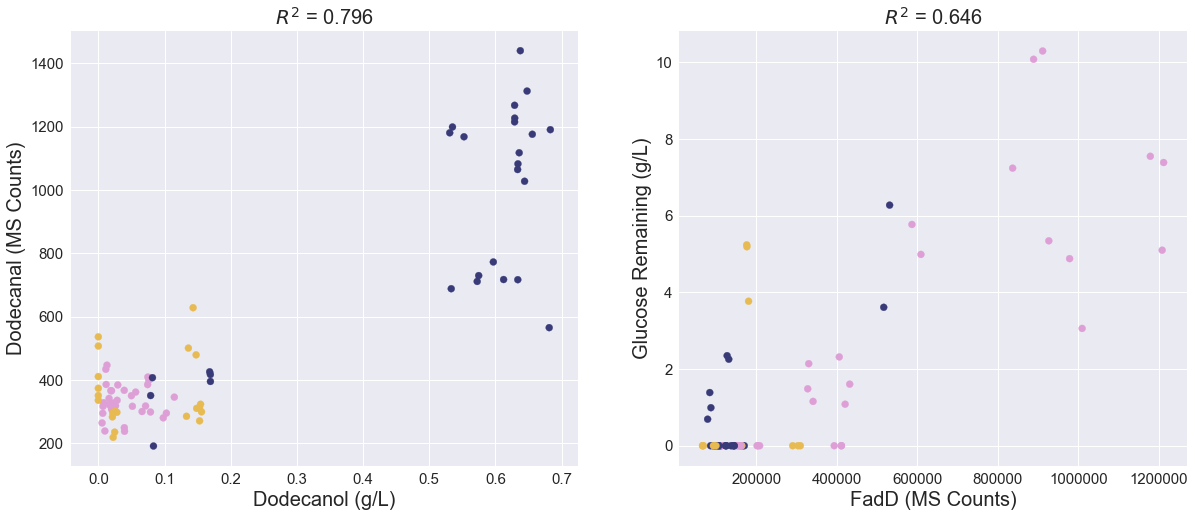

In [32]:
#Plt Figures for Harry
#print(list(df.columns))

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

import matplotlib.pylab as pylab
params = {
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)

#
plt.figure(figsize=(20,8))
fig = plt.subplot(1,2,1)

plt.scatter(df[('GC-MS', 'Dodecanoate (n-C12:0)')],df[('NIMS', 'C12 aldehyde saturated')],c=df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
plt.xlabel('Dodecanol (g/L)')
plt.ylabel('Dodecanal (MS Counts)')
plt.title('$R^2$ = {:0.3f}'.format(0.89215**2))

plt.subplot(1,2,2)
plt.scatter(df[('Targeted Proteomics', 'LCFA_ECOLI')],df[('HPLC', 'D-Glucose')],c=df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
plt.xlabel('FadD (MS Counts)')
plt.ylabel('Glucose Remaining (g/L)')
plt.title('$R^2$ = {:0.3f}'.format(0.646))

plt.show()

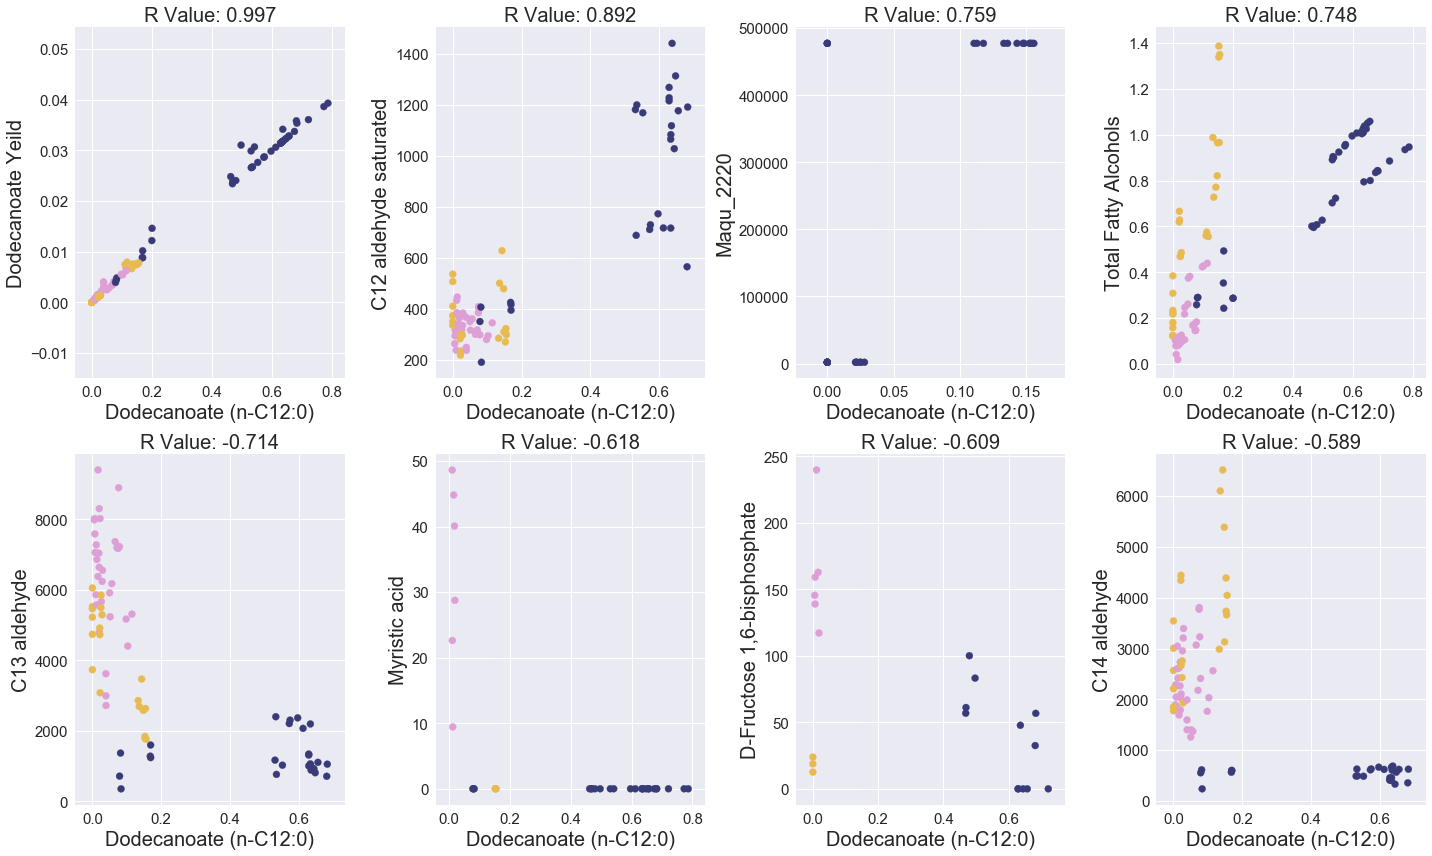

In [33]:
#Plot Top 8 Significant Correlations wit dodecanol
dodecanol_corr_df = correlation_df.loc[correlation_df['Feature 1']==('GC-MS','Dodecanoate (n-C12:0)')].sort_values('R^2 Value',ascending=False)[0:8]

plt.figure(figsize=(20,12))
for i,correlation in enumerate(dodecanol_corr_df.iterrows()):
    plt.subplot(2,4,i+1)
    #print(correlation)
    columns = [correlation[1]['Feature 1'],correlation[1]['Feature 2']]
    R = correlation[1]['R Value']
    temp_df = df[columns + [('Metadata','Pathway Variant')]].dropna()
    for column in columns:
        if column[0] in zero_drop_columns:
            temp_df[column] = temp_df.loc[(temp_df[column] != 0),column]
            
    X = temp_df[columns[0]]
    Y = temp_df[columns[1]]
    plt.scatter(X,Y,c=temp_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
    plt.xlabel(columns[0][1])
    plt.ylabel(columns[1][1])
    plt.title('R Value: {:0.3f}'.format(R))
plt.tight_layout()
plt.show()
    

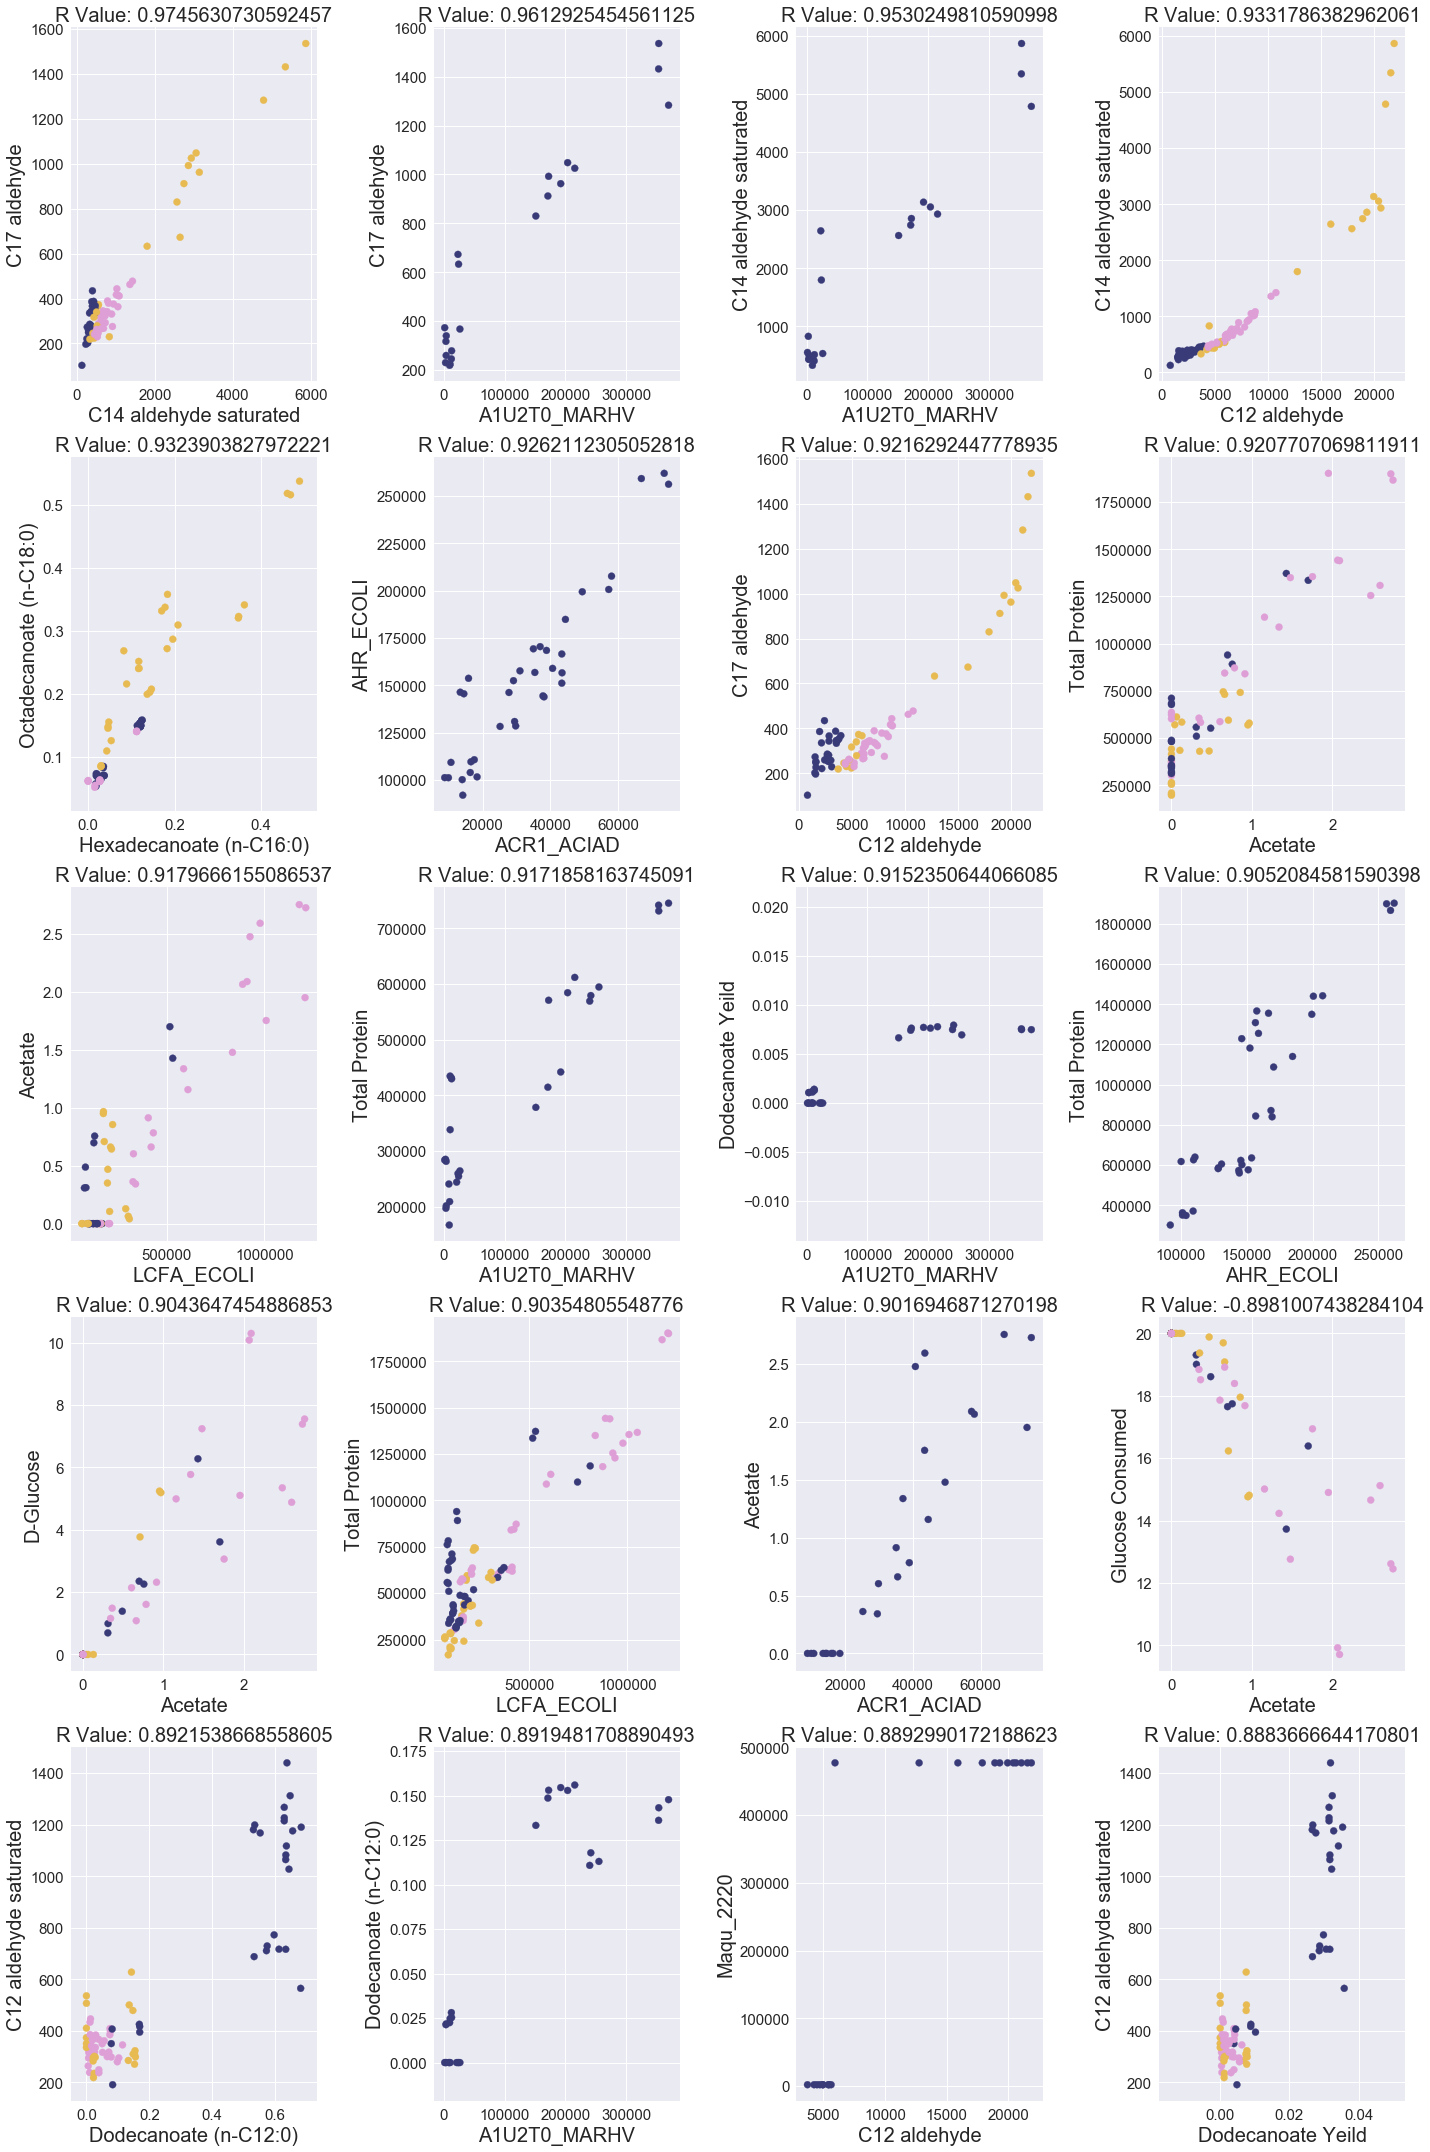

In [34]:
#Plot Top 20 Significant Correlations
corr_df = correlation_df[correlation_df['P Value']< 0.05 / total_comparisons].sort_values('R^2 Value',ascending=False)[11:]

plt.figure(figsize=(20,30))
i = 0
for correlation in corr_df.iterrows():
    columns = [correlation[1]['Feature 1'],correlation[1]['Feature 2']]
    if i == 20: break

    if 'LC-MS' not in [columns[0][0],columns[1][0]]:
        plt.subplot(5,4,i+1)
        #print(correlation)
        R = correlation[1]['R Value']
        temp_df = df[columns + [('Metadata','Pathway Variant')]].dropna()
        for column in columns:
            if column[0] in zero_drop_columns:
                temp_df[column] = temp_df.loc[(temp_df[column] != 0),column]
            
        X = temp_df[columns[0]]
        Y = temp_df[columns[1]]
        plt.scatter(X,Y,c=temp_df[('Metadata','Pathway Variant')],cmap=plt.get_cmap('tab20b'))
        plt.xlabel(columns[0][1])
        plt.ylabel(columns[1][1])
        plt.title('R Value: {}'.format(R))
        i += 1
        
plt.tight_layout()
plt.show()


In [35]:
# Plot some Expected Correlations where there Should be one but isn't
#print(list(df.columns))
correlation_pairs = [[('GC-MS','Dodecanoate (n-C12:0)'),('Targeted Proteomics','A1U3L3_MARHV')],
                     [('GC-MS','Total Fatty Alcohols'),('Targeted Proteomics','AHR_ECOLI')],
                     [('HPLC', 'D-Glucose'),('HPLC', 'Glucose Consumed')],
                     [('Targeted Proteomics','LCFA_ECOLI'),('HPLC','D-Glucose')],
                     [('Targeted Proteomics','Total Protein'),('GC-MS','Dodecanoate (n-C12:0)')],
                     [('LC-MS', 'Flavin adenine dinucleotide oxidized'),('LC-MS', 'Nicotinamide adenine dinucleotide')],
                     [('GC-MS','Dodecanoate (n-C12:0)'),('NIMS','C12 aldehyde saturated')],
                     [('LC-MS', 'Nicotinamide adenine dinucleotide phosphate - reduced'),('Targeted Proteomics', 'A1U3L3_MARHV')],
                     [('LC-MS', 'Nicotinamide adenine dinucleotide phosphate - reduced'),('Targeted Proteomics', 'A1U2T0_MARHV')]
                    ]

# Plot Interesting Correlations
#for pair in correlation_pairs:
    #g = sns.regplot(x=df[pair[0]], y=df[pair[1]],ci=95,robust=False)
    #plt.show()

In [36]:
# Mutual Information Analysis :: Use (Steuer et. al. 2002)
from scipy.special import digamma as psi
from scipy.spatial.distance import pdist,squareform
def mutual_information(X,Y,k=3):
    '''Estimate Mutual Information using:
       Kraskov, A., Stögbauer, H., & Grassberger, P. (2004). 
       Estimating mutual information. Physical review E, 69(6), 066138.
       
       Mutual Information is Estimated By:
       I(X,Y) = Psi(k) - 1/k - {Psi(n_x) + Psi(n_y)} + Psi(N)
       
       Where Psi is the digamma function, N is the number of observations in both X and Y.
    '''
    assert(len(X)==len(Y))
    
    N = len(X) #Total Number of Measurements
    
    #Distances Between All Points
    X_dist = squareform(pdist(X,'euclidean'))
    Y_dist = squareform(pdist(Y,'euclidean'))
    Z_dist = np.maximum(X_dist,Y_dist)
    #print(Z_dist)
    
    #Distance of kth closest neighbor for the ith observation of vector X and Y respectively
    #k=5
    #for k in range(20):
    Z_sort = np.argsort(Z_dist,axis=1)[:,k]

    #Not Sure I calculated Epsilon Correctly...
    eps_x = X_dist[Z_sort,np.arange(N)]
    eps_y = Y_dist[Z_sort,np.arange(N)]
    eps_z = np.maximum(eps_x,eps_y)
    #eps_x = np.sort(X_dist,axis=0)[k,:]
    #eps_y = np.sort(X_dist,axis=0)[k,:]
    #print(eps_z[0])

    n_x = np.sum(np.less(X_dist,eps_z),axis=1)
    n_y = np.sum(np.less(Y_dist,eps_z),axis=1)
    #print(n_x)
    #print(n_y)
    
    #print(psi(N),psi(k),np.mean(psi(n_x) + psi(n_y)))
    I = psi(k) - np.mean(psi(n_x+1) + psi(n_y+1)) + psi(N)
    return I
    
def plot_mi(df,title='',mask_insignificant=True):
    sns.set(style="white")
    plt.figure(figsize=(14,8))
    n = len(df.columns)

    
    # Compute the correlation matrix
    desired_cols = ['HPLC','GC-MS','Targeted Proteomics','Metabolomics','NIMS']
    for column1,column2 in itertools.combinations(df.loc[:,df.columns.get_level_values(0).isin(desired_cols)],2):
        #print(column1,column2)
        X = df[column1].fillna(0).values
        #X = StandardScaler().fit_transform(np.reshape(X,(len(X),1)))
        X = np.reshape(X,(len(X),1))
        
        Y = df[column2].fillna(0).values
        #Y = StandardScaler().fit_transform(np.reshape(Y,(len(Y),1)))
        Y = np.reshape(Y,(len(Y),1))
        
        #print(len(X))
        #for i in range(1,20):
        I = mutual_information(X,Y,k=3)
        P = pearsonr(X,Y)
        if I > 1:
            print(column1,column2)
            print('Mutual Information: {} Pearson R: {:.1f}  P Value: {}'.format(I,P[0][0]*100,P[1][0]))
            plt.scatter(X,Y)
            plt.xlabel(column1)
            plt.ylabel(column2)
            plt.show()
    

    # Generate a mask for the upper triangle
    #mask = np.zeros_like(corr, dtype=np.bool)
    #mask[np.triu_indices_from(mask)] = True
    
    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #ax = sns.heatmap(corr,annot=True,square=True,mask=mask,fmt='0.3g',cmap=cmap,linewidths=.5)

    #plt.title(title)
    #plt.show()


#X = df[('GC-MS','Dodecanoate (n-C12:0)')].values
#X = np.reshape(StandardScaler().fit_transform(X),(len(X),1))

#Y = df[('Targeted Proteomics','A1U3L3_MARHV')].values
#Y = np.reshape(StandardScaler().fit_transform(Y),(len(Y),1))
#print(len(X))
#for i in range(1,20):
#print(mutual_information(X,Y,k=1))
#plot_mi(df)   


# 1.3 Cycle 1: Use ART to Reccomend Strain Designs

There are 2 Objectives for Art, Maximize Yeild and Maximize Titer.  Additionally there are 4 different phase spaces to consider: 
1. Pathway 1: maqu_2220
2. Pathway 2: maqu_2507
3. Pathway 3: yjgB & acr1 
4. Combined Pathway

This makes for 8 total analyses to run. From each analysis we will reccomend 10 strains to build. First We have to create CSVs Which ART Accepts from our Existing Data Frames. First Set up Art Parameters for running:

In [37]:
#Setup ART Parameters
from AutomaticRecommendationTool.art import recommendation_engine

art_params = {}
art_params['data_file'] = 'tmp/generated_data.csv' #Data File From EDD -- Going to Need Strain Information from ICE too...
#art_params['phase_space_file'] = 'tmp/generated_phase_space.csv' #Phase Space Definition
#art_params['strain_file'] = 'tmp/generated_strain_design.csv' #List of Strain Definitions

#Set as proteins only for now... (make sure art is doing the right thing with this data)
features = list(df.loc[:,df.columns.get_level_values(0)=='Targeted Proteomics'].columns.get_level_values(1))
art_params['features']  = None   

#Set as dodecanol c12 fatty alcohol
art_params['target'] = ['Dodecanoate (n-C12:0)',] # Maybe use Growth Rate Instead??
art_params['objective_dict'] = {'objective':'maximize','threshold':0.20}
art_params['num_strains'] = 16
art_params['engineering_accuracy'] = 0.5
art_params['verbose'] = 2
art_params['tpot_dict'] = {'generations':20,'population_size':100}
art_params['seed'] = 8311

In [38]:
#Apply function to melted columns to make exportable Dataframe
def find_tir(row):
    index = row['Line Name']
    gene = row['Gene']
    tir = df[('TIR',gene)].loc[index]
    return tir

#Create RBS ID (RBS_$GeneName$_$TIR$)
def make_rbs_id(row):
    return 'RBS_{}_{}'.format(row['Gene'],row['TIR'])

#Create Part Type for each Row
def make_part_id(row):
    return '{}_RBS'.format(row['Gene'])

def set_order(row):
    order_dict = {
        'UcFatB1_RBS':1,
        'FadD_RBS':2,
        'Maqu_2507_RBS':3,
        'Maqu_2220_RBS':4,
        'acr1_RBS':5,
        'yjgB_RBS':6,
    }
    return order_dict[row['Part']]

In [39]:
#Create Strain Design CSV
def strain_design_csv(df,line_names,id_cols):
    #Melt Dataframe to Get ID for Strain RBS
    strain_design_df = pd.melt(df.reset_index(),id_vars=[('Line Name','')], value_vars=id_cols)
    strain_design_df.columns = ['Line Name','Protcol','Gene','RBS']

    #Apply Operations to Rows
    strain_design_df['TIR'] = strain_design_df.apply(find_tir,axis=1)
    strain_design_df['ID'] = strain_design_df.apply(make_rbs_id,axis=1)
    strain_design_df['Part'] = strain_design_df.apply(make_part_id,axis=1)
    strain_design_df['Order'] = strain_design_df.apply(set_order,axis=1)
    #print(strain_design_df['Part'].unique())

    #Write out CSV
    strain_design_df = strain_design_df.loc[strain_design_df['Line Name'].isin(line_names)]
    #display(strain_design_df)
    strain_design_df[['Line Name','Part','ID','Order']].set_index('Line Name').to_csv('generated_strain_design.csv')
    return strain_design_df

In [40]:
#Create Phase Space CSV
def phase_space_csv(strain_design_df):
    #Get Existing Phase Space from strain_design_df
    phase_space_df = strain_design_df[['ID','Part','TIR']].drop_duplicates()

    #for each Part Type Create Evenly spaced interpolated values from zero to 150% of max
    max_rbs_scale = 5
    num_rbs = 5
    parts = phase_space_df.groupby('Part')

    for part in parts:
        part_name = part[0]
        max_tir = max(part[1]['TIR'])
        #print(max_tir)

        #Create New Dataframe with additional TIR Vals
        tir_vals = np.linspace(0,max_tir*max_rbs_scale,num_rbs+1).tolist()
        part_names = [part_name]*num_rbs
        part_ids = ['{}_{:.0f}'.format(part_name,tir) for tir in tir_vals[1:]]
        d = {'ID':part_ids,'Part':part_names,'TIR':tir_vals[1:]}
        temp_df = pd.DataFrame(data=d)
        phase_space_df = phase_space_df.append(temp_df)
        #display(phase_space_df)

    #parts = phase_space_df.groupby('Part')
    #for part in parts:
    #    display(part[1])

    #Add a range of Values Associated with other RBS Choices
    phase_space_df.columns = ['ID','Type','Feature 1']
    phase_space_df.set_index('ID').to_csv('generated_phase_space.csv')

In [41]:
#Create EDD Style Data CSV
#Cols
#Line Name / Measurement Type / 0
def edd_csv(df,line_names):
    edd_df = pd.melt(df.reset_index(),id_vars=[('Line Name','')], value_vars=list(mean_df.columns))
    edd_df.columns = ['Line Name','Protocol Name','Measurement Type',0.0]
    edd_df = edd_df[['Line Name','Protocol Name','Measurement Type',0.0]].loc[edd_df['Line Name'].isin(line_names)]
    edd_df.set_index('Line Name').to_csv('generated_data.csv')

Run ART

In [42]:
targets = ['yeild','titer']
pathway_ids = {1:[('Metadata','Maqu_2507')], 
               2:[('Metadata','Maqu_2220')], 
               3:[('Metadata','acr1'), ('Metadata','yjgB')],
               4:[('Metadata','Maqu_2507'),('Metadata','Maqu_2220'),('Metadata','acr1'), ('Metadata','yjgB')]
              }

targets = ['titer']

modes = ['Protein']
extrapolation_constants = [1.5]
pathway_variants = [2,1]


features = {1:['FATB_UMBCA','LCFA_ECOLI','A1U3L3_MARHV'],
            2:['FATB_UMBCA','LCFA_ECOLI','A1U2T0_MARHV'],
            3:['FATB_UMBCA','LCFA_ECOLI','ACR1_ACIAD','AHR_ECOLI'],
            4:['FATB_UMBCA','LCFA_ECOLI','A1U3L3_MARHV','A1U2T0_MARHV','ACR1_ACIAD','AHR_ECOLI'],        
}


model_evals = []
for target,mode,extrapolation_constant,pathway_variant in itertools.product(targets,modes,extrapolation_constants,pathway_variants):
    
    #print(target,mode,extrapolation_constant,pathway_variant)
    
    #Set Simulation Variables for Target
    if target == 'titer':
        art_params['target'] = 'Dodecanoate (n-C12:0)'
        art_params['target_units'] = 'g/L'
    else:
        art_params['target'] = 'Dodecanoate Yeild'
        art_params['target_units'] = 'g/(L*g_glc)'
      
    #Set Extrapolation Constant
    art_params['extrapolation_constant'] = extrapolation_constant
    
    #Set Pathway Variant    
    valid_lines = list(df.loc[df[('Metadata','Pathway Variant')]==pathway_variant].index.unique())
    #print(valid_lines)
    
    
    
    #Select Pathway Parts To Use
    id_cols = [('Metadata','UcFatB1'), ('Metadata','FadD')] + pathway_ids[pathway_variant]
        
    #Add Intermediate Features
    art_params['features'] = features[pathway_variant]
        
    #Set Mode
    edd_csv(df,valid_lines)
    if mode == 'Protein':
        art_params['phase_space_file'] = None
        art_params['strain_file'] = None
        art_params['engineering_accuracy'] = 0.5
        
        #Set Engineering Strains
        art_params['engineering_base_strains'] = valid_lines
    
    else:        
        strain_design_df = strain_design_csv(df,valid_lines,id_cols)
        phase_space_csv(strain_design_df)
        art_params['phase_space_file'] = 'generated_phase_space.csv' 
        art_params['strain_file'] = 'generated_strain_design.csv'
        art_params['engineering_accuracy'] = 0.0
        art_params['engineering_base_strains'] = None

        
    #Create Report Heading
    pathway_title = pathway_ids[pathway_variant][0][1]
    title = '<h1>{} {} Maximization Report. Mode: {} Predictions. Extrapolating by {}x</h1>'.format(pathway_title,target,mode,extrapolation_constant)   
    display(HTML(title))
    
    #Run ART
    art = recommendation_engine(**art_params)
    
    #Genearate Report (Skip Report Generation For Now...)
    #art.generate_report()
    model_evals.append(art)


Independent Variables                          Dependent Variable
                   A1U2T0_MARHV FATB_UMBCA LCFA_ECOLI Dodecanoate (n-C12:0)
Line Name                                                                  
b1-15-1                  8372.0    59741.0   164171.0               0.00000
b1-15-2                 10438.0    83972.0   240185.0               0.00000
b1-16-1                 21091.0   105024.0   115367.0               0.00000
b1-16-2                  8954.0    73675.0    84540.0               0.00000
b2-19-1                192296.0    73678.0   163117.0               0.15449
b2-19-2                171189.0    73549.0   163881.0               0.14858
b2-19-3                151364.0    72968.0   153324.0               0.13323
b2-31-1                  2850.0   188519.0    93821.0               0.00000
b2-31-2                  3875.0   180955.0    96694.0               0.00000
b2-31-3                  1455.0   184261.0    96589.0               0.00000
b2-32-1                353284.0   163592.0   223440.0               0.13608
b2-32-2                353541.0   163693.0   212751.0               0.14315
b2-32-3                369664.0   157030.0   217714.0               0.14770
b2-33-1                255153.0   156275.0   180662.0               0.11299
b2-33-2                239988.0   148812.0   176053.0               0.11077
b2-33-3                241808.0   158485.0   176585.0               0.11784
b2-34-1                 23320.0   168689.0    66185.0               0.00000
b2-34-2                 24299.0   162770.0    66880.0               0.00000
b2-34-3                 26490.0   167169.0    68351.0               0.00000
b3-13-1                 12448.0   210505.0   198841.0               0.02808
b3-13-2                 12835.0   218624.0   196947.0               0.02529
b3-13-3                 10366.0   216250.0   208068.0               0.02469
b3-16-1                  4053.0    98067.0    99672.0               0.02176
b3-16-2                  3475.0    98633.0    94673.0               0.02127
b3-16-3                  9574.0   105837.0    93288.0               0.02242
b3-18-1                215377.0    91015.0   303399.0               0.15592
b3-18-2                203658.0    87990.0   290265.0               0.15287
b3-18-3                172397.0    88388.0   309202.0               0.15298

Version 0.9.2 of tpot is outdated. Version 0.9.3 was released 22 hours ago.


Optimization Progress:  10%|▉         | 200/2100 [00:43<15:38,  2.03pipeline/s]

Generation 1 - Current best internal CV score: -0.000305766740280811


Optimization Progress:  14%|█▍        | 300/2100 [01:08<05:57,  5.04pipeline/s]

Generation 2 - Current best internal CV score: -0.000305766740280811


Optimization Progress:  19%|█▉        | 400/2100 [01:39<09:00,  3.14pipeline/s]

Generation 3 - Current best internal CV score: -0.0003003021186711121


Optimization Progress:  24%|██▍       | 500/2100 [02:20<06:46,  3.94pipeline/s]  

Generation 4 - Current best internal CV score: -0.0003003021186711121


Optimization Progress:  29%|██▊       | 600/2100 [03:03<10:04,  2.48pipeline/s]  

Generation 5 - Current best internal CV score: -0.00023475570799491948


Optimization Progress:  33%|███▎      | 700/2100 [03:44<08:32,  2.73pipeline/s]

Generation 6 - Current best internal CV score: -0.00023475570799491948


Optimization Progress:  38%|███▊      | 800/2100 [04:27<05:27,  3.97pipeline/s]

Generation 7 - Current best internal CV score: -0.00023475570799491948


Optimization Progress:  43%|████▎     | 900/2100 [04:53<04:18,  4.64pipeline/s]

Generation 8 - Current best internal CV score: -0.00023475570799491948


Optimization Progress:  48%|████▊     | 1000/2100 [05:20<03:29,  5.25pipeline/s]

Generation 9 - Current best internal CV score: -0.00023475570799491948


Optimization Progress:  52%|█████▏    | 1100/2100 [05:51<07:24,  2.25pipeline/s]

Generation 10 - Current best internal CV score: -0.00022544336398994512


Optimization Progress:  57%|█████▋    | 1200/2100 [06:13<05:08,  2.91pipeline/s]

Generation 11 - Current best internal CV score: -0.00022544336398994512


Optimization Progress:  62%|██████▏   | 1300/2100 [06:31<02:52,  4.65pipeline/s]

Generation 12 - Current best internal CV score: -0.00020953592575604106


Optimization Progress:  67%|██████▋   | 1400/2100 [06:41<01:28,  7.95pipeline/s]

Generation 13 - Current best internal CV score: -0.00020953592575604106


Optimization Progress:  71%|███████▏  | 1500/2100 [06:53<00:55, 10.89pipeline/s]

Generation 14 - Current best internal CV score: -0.00020953592575604106


Optimization Progress:  76%|███████▌  | 1600/2100 [07:03<01:10,  7.11pipeline/s]

Generation 15 - Current best internal CV score: -0.00020953592575604106


Optimization Progress:  81%|████████  | 1700/2100 [07:18<00:40,  9.80pipeline/s]

Generation 16 - Current best internal CV score: -0.00020695409396870798


Optimization Progress:  86%|████████▌ | 1800/2100 [07:27<00:18, 16.48pipeline/s]

Generation 17 - Current best internal CV score: -0.00020695409396870798


Optimization Progress:  90%|█████████ | 1900/2100 [07:40<00:24,  8.03pipeline/s]

Generation 18 - Current best internal CV score: -0.00020695409396870798


Optimization Progress:  95%|█████████▌| 2000/2100 [07:58<00:34,  2.89pipeline/s]

Generation 19 - Current best internal CV score: -0.00020695409396870798


Generation 20 - Current best internal CV score: -0.00020695409396870798

Best pipeline: RandomForestRegressor(ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=13, min_samples_split=15, n_estimators=100), bootstrap=False, max_features=0.3, min_samples_leaf=9, min_samples_split=4, n_estimators=100), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=5, min_samples_split=15, n_estimators=100)


Model
Name                                                                      
Random Forest Regressor  (DecisionTreeRegressor(criterion='mse', max_de...
Polynomial Regressor     Pipeline(memory=None,\n     steps=[('Scaler', ...
Neural Regressor         Pipeline(memory=None,\n     steps=[('Scaling',...
TPOT Regressor           Pipeline(memory=None,\n     steps=[('stackinge...

Model  \
Name                                                                         
Random Forest Regressor  (DecisionTreeRegressor(criterion='mse', max_de...   
Polynomial Regressor     Pipeline(memory=None,\n     steps=[('Scaler', ...   
Neural Regressor         Pipeline(memory=None,\n     steps=[('Scaling',...   
TPOT Regressor           Pipeline(memory=None,\n     steps=[('stackinge...   

                                                               Predictions  \
Name                                                                         
Random Forest Regressor  [0.022235833333333333, 0.02449183333333333, 0....   
Polynomial Regressor     [0.05683125782668294, 0.07824130183408853, 0.0...   
Neural Regressor         [0.1591686317638542, 0.1868890366339805, -0.03...   
TPOT Regressor           [0.011039230769230763, 0.07240439999999992, 0....   

                         Error Mean  Error Standard Deviation  
Name                                                           
Random Forest Regressor   -0.000689                  0.013369  
Polynomial Regressor       0.001314                  0.027584  
Neural Regressor           0.006596                  0.120369  
TPOT Regressor            -0.002243                  0.020536

differential_evolution step 1: f(x)= -61.383
differential_evolution step 2: f(x)= -61.5909
differential_evolution step 3: f(x)= -61.5909
differential_evolution step 4: f(x)= -61.5909
differential_evolution step 5: f(x)= -61.8196
differential_evolution step 6: f(x)= -61.8196
differential_evolution step 7: f(x)= -61.8196
differential_evolution step 8: f(x)= -61.8196
differential_evolution step 9: f(x)= -61.8448
differential_evolution step 10: f(x)= -61.9484
differential_evolution step 11: f(x)= -61.9484
differential_evolution step 12: f(x)= -61.9628
differential_evolution step 13: f(x)= -61.9628
differential_evolution step 1: f(x)= -59.6357
differential_evolution step 2: f(x)= -59.6357
differential_evolution step 3: f(x)= -59.9472
differential_evolution step 4: f(x)= -60.5846
differential_evolution step 5: f(x)= -60.5846
differential_evolution step 6: f(x)= -60.5846
differential_evolution step 7: f(x)= -60.5846
differential_evolution step 8: f(x)= -60.5846
differential_evolution step 9: 

differential_evolution step 8: f(x)= -44.2186
differential_evolution step 9: f(x)= -44.2186
differential_evolution step 10: f(x)= -45.3472
differential_evolution step 11: f(x)= -45.3472
differential_evolution step 12: f(x)= -46.3498
differential_evolution step 13: f(x)= -46.3498
differential_evolution step 14: f(x)= -46.3498
differential_evolution step 15: f(x)= -46.3498
differential_evolution step 16: f(x)= -46.3498
differential_evolution step 17: f(x)= -46.3498
differential_evolution step 18: f(x)= -46.3498
differential_evolution step 19: f(x)= -46.3874
differential_evolution step 20: f(x)= -46.3874
differential_evolution step 21: f(x)= -46.5872
differential_evolution step 22: f(x)= -46.5872
differential_evolution step 23: f(x)= -46.7294
differential_evolution step 24: f(x)= -46.7294
differential_evolution step 25: f(x)= -47.2524
differential_evolution step 26: f(x)= -47.2524
differential_evolution step 27: f(x)= -47.2524
differential_evolution step 28: f(x)= -47.2524
differential_ev

differential_evolution step 12: f(x)= -38.9844
differential_evolution step 13: f(x)= -38.9844
differential_evolution step 14: f(x)= -39.1873
differential_evolution step 15: f(x)= -39.2271
differential_evolution step 16: f(x)= -39.2271
differential_evolution step 17: f(x)= -39.2271
differential_evolution step 18: f(x)= -39.2271
differential_evolution step 19: f(x)= -39.2271
differential_evolution step 20: f(x)= -39.2821
differential_evolution step 21: f(x)= -39.3206
differential_evolution step 22: f(x)= -39.3206
differential_evolution step 1: f(x)= -33.1996
differential_evolution step 2: f(x)= -36.6661
differential_evolution step 3: f(x)= -36.9821
differential_evolution step 4: f(x)= -37.2619
differential_evolution step 5: f(x)= -37.2619
differential_evolution step 6: f(x)= -37.2619
differential_evolution step 7: f(x)= -37.2619
differential_evolution step 8: f(x)= -38.5459
differential_evolution step 9: f(x)= -38.5459
differential_evolution step 10: f(x)= -38.5459
differential_evolution

differential_evolution step 12: f(x)= -33.3885
differential_evolution step 13: f(x)= -33.3885
differential_evolution step 14: f(x)= -33.3885
differential_evolution step 15: f(x)= -33.3885
differential_evolution step 16: f(x)= -33.3885
differential_evolution step 17: f(x)= -33.3885
differential_evolution step 18: f(x)= -33.3885
differential_evolution step 19: f(x)= -33.3885
differential_evolution step 20: f(x)= -33.3885
differential_evolution step 21: f(x)= -33.6483
differential_evolution step 22: f(x)= -33.6483
differential_evolution step 23: f(x)= -33.7727
differential_evolution step 24: f(x)= -33.7727
differential_evolution step 25: f(x)= -33.7727
differential_evolution step 26: f(x)= -33.7727
differential_evolution step 27: f(x)= -33.8442
differential_evolution step 28: f(x)= -33.8442
differential_evolution step 29: f(x)= -33.8442
differential_evolution step 30: f(x)= -33.846
differential_evolution step 31: f(x)= -33.846
differential_evolution step 32: f(x)= -33.846
differential_evo

FATB_UMBCA     LCFA_ECOLI   A1U2T0_MARHV   Success Probability  \
0   451915.523940   21362.765982  364115.934811  [61.962788992866805]   
1   456390.612978   22880.134009   25108.866577               60.6081   
2   299376.071954   20471.088452    7445.122573   [58.94843112067096]   
3   461219.524886   20066.927759  206073.776627  [58.194054968547704]   
4   292836.486941   20388.200090  369891.041829   [58.42638890584614]   
5   364967.659799  110624.534746  119515.085226   [49.68724793791753]   
6   461158.541682  157880.968406  284633.762864     [47.277764376978]   
7   275279.975346   20021.074171  212857.596494   [48.80582717147438]   
8   168723.571342   20049.039789   96218.134025   [40.87713475941761]   
9   371240.698764  258115.666178  367395.841876   [39.32059811052241]   
10  460790.054299  179725.736225    5459.110204   [43.04800270200135]   
11  461636.709410  242202.431079  151071.485014   [38.58761009009163]   
12  317456.925588  258083.558713  218082.949171   [35.97060860618586]   
13  213535.552153  256015.186969  357491.607288  [35.662436927299225]   
14  333496.760498  256367.535387   59352.669483   [34.03781902845226]   
15  134858.658205   20139.813965  368703.550835   [36.92836652735784]   

    Random Forest Regressor  Polynomial Regressor  Neural Regressor  \
0                  0.144872              0.458108          0.611153   
1                  0.132776              0.459567          1.229450   
2                  0.119125              0.305092          1.006726   
3                  0.140051              0.470157          0.368756   
4                  0.128690              0.298562          0.534436   
5                  0.132776              0.227013          0.497479   
6                  0.145816              0.188808          0.234006   
7                  0.123869              0.281178          0.021587   
8                  0.136771              0.172807          0.289488   
9                  0.144378             -0.010022          0.574186   
10                 0.136922              0.144114          0.852039   
11                 0.136922              0.016706          0.550236   
12                 0.139363             -0.006535          0.582705   
13                 0.149380              0.001998          0.414659   
14                 0.133184             -0.005052          0.257697   
15                 0.147843              0.138325          0.396699   

    TPOT Regressor  
0         0.138883  
1         0.138883  
2         0.138883  
3         0.138883  
4         0.138883  
5         0.138883  
6         0.138883  
7         0.138883  
8         0.138883  
9         0.138883  
10        0.138883  
11        0.138883  
12        0.138883  
13        0.138883  
14        0.138883  
15        0.138883

Independent Variables                          Dependent Variable
                   A1U3L3_MARHV FATB_UMBCA LCFA_ECOLI Dodecanoate (n-C12:0)
Line Name                                                                  
b1-01-1                159144.0   131969.0   111883.0               0.72127
b1-01-2                173165.0   155128.0   109006.0               0.65691
b1-02-1                158408.0   123692.0   106977.0               0.67474
b1-02-2                155221.0   161836.0   110415.0               0.46250
b1-04-1                565758.0   114226.0    79192.0               0.46831
b1-04-2                579082.0   117131.0    84364.0               0.46912
b1-08-1                202718.0   113884.0   165598.0               0.77272
b1-08-2                204510.0   107398.0   169995.0               0.78618
b1-09-1                207289.0   136812.0   745982.0               0.47953
b1-09-2                232565.0   142616.0   810667.0               0.49699
b1-11-1                686451.0    73491.0   131484.0               0.53039
b1-11-2                736006.0    76212.0   127385.0               0.54166
b1-12-1                740579.0    76399.0   516401.0               0.19996
b1-12-2                762921.0    77474.0   530998.0               0.20065
b2-11-1                360114.0    61346.0    87148.0               0.68117
b2-11-2                405148.0    69825.0    78968.0               0.68290
b2-11-3                400045.0    67842.0    84297.0               0.63582
b3-01-1                121953.0   142442.0    94257.0               0.64397
b3-01-2                110232.0   137559.0    86387.0               0.62890
b3-01-3                116728.0   140317.0    92864.0               0.62889
b3-02-1                119671.0   139410.0    97136.0               0.63397
b3-02-2                135795.0   147915.0   107045.0               0.63347
b3-02-3                188926.0   153000.0   144772.0               0.62905
b3-03-1                138378.0   125322.0   355038.0               0.16820
b3-03-2                135131.0   131057.0   369437.0               0.16936
b3-03-3                120677.0   125472.0   337160.0               0.16928
b3-05-1                432873.0   107258.0    83145.0               0.53089
b3-05-2                439249.0   109847.0    83962.0               0.53505
b3-05-3                471032.0   107696.0    90099.0               0.55245
b3-06-1                215241.0    50149.0   167575.0               0.08332
b3-06-2                217714.0    53004.0   186630.0               0.07902
b3-06-3                247382.0    53533.0   213883.0               0.08180
b3-07-1                 99544.0   103613.0   145026.0               0.53316
b3-07-2                 96436.0   101283.0   142235.0               0.57466
b3-07-3                105513.0   103892.0   136986.0               0.57237
b3-08-1                 87508.0   105707.0   123104.0               0.63372
b3-08-2                 87744.0   107000.0   125883.0               0.61229
b3-08-3                 82715.0   104239.0   124508.0               0.59677
b3-10-1                499232.0    77657.0   106078.0               0.63755
b3-10-2                532764.0    74213.0   102990.0               0.64773
b3-10-3                503145.0    74197.0   100254.0               0.65566

Version 0.9.2 of tpot is outdated. Version 0.9.3 was released 22 hours ago.


Optimization Progress:  10%|▉         | 200/2100 [00:46<14:53,  2.13pipeline/s]

Generation 1 - Current best internal CV score: -0.034002649508392845


Optimization Progress:  14%|█▍        | 300/2100 [01:13<07:07,  4.21pipeline/s]

Generation 2 - Current best internal CV score: -0.033875024141770474


Optimization Progress:  19%|█▉        | 400/2100 [01:53<09:56,  2.85pipeline/s]  

Generation 3 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  24%|██▍       | 500/2100 [02:18<08:18,  3.21pipeline/s]

Generation 4 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  29%|██▊       | 600/2100 [02:36<03:46,  6.62pipeline/s]

Generation 5 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  33%|███▎      | 700/2100 [02:49<03:43,  6.25pipeline/s]

Generation 6 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  38%|███▊      | 800/2100 [03:04<05:30,  3.93pipeline/s]

Generation 7 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  43%|████▎     | 900/2100 [03:16<03:18,  6.05pipeline/s]

Generation 8 - Current best internal CV score: -0.031132707449942086


Optimization Progress:  48%|████▊     | 1000/2100 [03:31<04:04,  4.50pipeline/s]

Generation 9 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  52%|█████▏    | 1100/2100 [03:42<03:45,  4.43pipeline/s]

Generation 10 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  57%|█████▋    | 1200/2100 [03:51<01:11, 12.57pipeline/s]

Generation 11 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  62%|██████▏   | 1300/2100 [04:03<01:21,  9.84pipeline/s]

Generation 12 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  67%|██████▋   | 1400/2100 [04:15<01:34,  7.41pipeline/s]

Generation 13 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  71%|███████▏  | 1500/2100 [04:31<02:22,  4.22pipeline/s]

Generation 14 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  76%|███████▌  | 1600/2100 [04:45<01:50,  4.51pipeline/s]

Generation 15 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  81%|████████  | 1700/2100 [04:58<00:37, 10.64pipeline/s]

Generation 16 - Current best internal CV score: -0.024875346055720254


Optimization Progress:  86%|████████▌ | 1800/2100 [05:06<00:24, 12.25pipeline/s]

Generation 17 - Current best internal CV score: -0.024875346055720247


Optimization Progress:  90%|█████████ | 1900/2100 [05:14<00:14, 13.61pipeline/s]

Generation 18 - Current best internal CV score: -0.024811690295811772


Optimization Progress:  95%|█████████▌| 2000/2100 [05:20<00:05, 16.77pipeline/s]

Generation 19 - Current best internal CV score: -0.024811690295811772


Generation 20 - Current best internal CV score: -0.024811690295811772

Best pipeline: DecisionTreeRegressor(LinearSVR(input_matrix, C=0.5, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=1e-05), max_depth=1, min_samples_leaf=11, min_samples_split=15)


Model
Name                                                                      
Random Forest Regressor  (DecisionTreeRegressor(criterion='mse', max_de...
Polynomial Regressor     Pipeline(memory=None,\n     steps=[('Scaler', ...
Neural Regressor         Pipeline(memory=None,\n     steps=[('Scaling',...
TPOT Regressor           Pipeline(memory=None,\n     steps=[('stackinge...

Model  \
Name                                                                         
Random Forest Regressor  (DecisionTreeRegressor(criterion='mse', max_de...   
Polynomial Regressor     Pipeline(memory=None,\n     steps=[('Scaler', ...   
Neural Regressor         Pipeline(memory=None,\n     steps=[('Scaling',...   
TPOT Regressor           Pipeline(memory=None,\n     steps=[('stackinge...   

                                                               Predictions  \
Name                                                                         
Random Forest Regressor  [0.6358815, 0.6364106666666667, 0.605958, 0.63...   
Polynomial Regressor     [0.6169519328184775, 0.6464087741603748, 0.609...   
Neural Regressor         [0.5847873878340121, 0.7097227937936913, 0.576...   
TPOT Regressor           [0.6119736, 0.6119736, 0.6119736, 0.6119736, 0...   

                         Error Mean  Error Standard Deviation  
Name                                                           
Random Forest Regressor   -0.017806                  0.246518  
Polynomial Regressor      -0.026786                  0.175435  
Neural Regressor          -0.027195                  0.264484  
TPOT Regressor            -0.004553                  0.185801

differential_evolution step 1: f(x)= -51.1488
differential_evolution step 2: f(x)= -52.0707
differential_evolution step 3: f(x)= -52.0707
differential_evolution step 4: f(x)= -52.0707
differential_evolution step 5: f(x)= -52.0707
differential_evolution step 6: f(x)= -53.4693
differential_evolution step 7: f(x)= -53.7246
differential_evolution step 8: f(x)= -53.7246
differential_evolution step 9: f(x)= -53.7246
differential_evolution step 10: f(x)= -53.7246
differential_evolution step 11: f(x)= -53.7349
differential_evolution step 12: f(x)= -53.7349
differential_evolution step 13: f(x)= -54.1082
differential_evolution step 14: f(x)= -54.1082
differential_evolution step 15: f(x)= -54.1082
differential_evolution step 16: f(x)= -54.1082
differential_evolution step 1: f(x)= -50.7794
differential_evolution step 2: f(x)= -50.7794
differential_evolution step 3: f(x)= -50.7794
differential_evolution step 4: f(x)= -50.7794
differential_evolution step 5: f(x)= -50.9023
differential_evolution step

differential_evolution step 5: f(x)= -44.3599
differential_evolution step 6: f(x)= -44.3599
differential_evolution step 7: f(x)= -44.694
differential_evolution step 8: f(x)= -45.9346
differential_evolution step 9: f(x)= -45.9346
differential_evolution step 10: f(x)= -45.9346
differential_evolution step 11: f(x)= -45.9346
differential_evolution step 12: f(x)= -46.0938
differential_evolution step 13: f(x)= -46.6416
differential_evolution step 14: f(x)= -46.7146
differential_evolution step 15: f(x)= -46.7177
differential_evolution step 16: f(x)= -46.8513
differential_evolution step 17: f(x)= -46.8513
differential_evolution step 18: f(x)= -46.8513
differential_evolution step 19: f(x)= -46.8513
differential_evolution step 20: f(x)= -46.8513
differential_evolution step 1: f(x)= -42.2667
differential_evolution step 2: f(x)= -42.2667
differential_evolution step 3: f(x)= -42.6439
differential_evolution step 4: f(x)= -42.7852
differential_evolution step 5: f(x)= -43.3946
differential_evolution s

differential_evolution step 8: f(x)= -36.3649
differential_evolution step 9: f(x)= -36.3649
differential_evolution step 10: f(x)= -36.3649
differential_evolution step 11: f(x)= -36.3649
differential_evolution step 12: f(x)= -40.0901
differential_evolution step 13: f(x)= -40.4047
differential_evolution step 14: f(x)= -40.4047
differential_evolution step 15: f(x)= -41.0025
differential_evolution step 16: f(x)= -41.0025
differential_evolution step 17: f(x)= -41.0025
differential_evolution step 18: f(x)= -41.0025
differential_evolution step 19: f(x)= -41.0025
differential_evolution step 20: f(x)= -41.0025
differential_evolution step 21: f(x)= -41.0025
differential_evolution step 22: f(x)= -41.0025
differential_evolution step 23: f(x)= -41.0025
differential_evolution step 24: f(x)= -41.0025
differential_evolution step 25: f(x)= -41.109
differential_evolution step 26: f(x)= -41.109
differential_evolution step 27: f(x)= -41.109
differential_evolution step 28: f(x)= -41.109
differential_evolut

FATB_UMBCA     LCFA_ECOLI   A1U3L3_MARHV   Success Probability  \
0   932358.525643  189702.376161  532448.210756  [54.108232306484695]   
1   925668.563423  189703.764161  779250.588991   [52.51224017899415]   
2   719764.380305  189124.830946  437982.388114   [50.44143856060488]   
3   834497.404870  189754.393833  993434.698224   [50.54198225071481]   
4   717595.875685  189724.457950  672648.879956    [50.0390005227592]   
5   622127.494754  189744.117404  900360.495839  [47.636287819601286]   
6   515829.750107  189453.683679  555990.424037  [46.851302355561344]   
7   931705.194263  189700.912939  300231.678851   [49.82794179037736]   
8   424068.844408  189582.059257  773891.450979   [44.72373672316892]   
9   516768.632733  189705.140326  321862.583191   [45.40509620992464]   
10  301441.325920  189579.453300  467672.352705   [43.43462752932088]   
11  205253.498230  189685.262315  865729.385678  [41.475141857036405]   
12  177140.903399  189726.788827  271041.783839  [41.348441107868574]   
13  791704.196923  188350.157193  113120.582724   [37.20521457207142]   
14  147396.458281  189723.526209  641085.346213   [40.79345534751656]   
15  403815.519985  189706.122494  114713.223845   [34.34823742864959]   

    Random Forest Regressor  Polynomial Regressor  Neural Regressor  \
0                  0.382997              2.064608          1.615986   
1                  0.384743              3.162318          1.573329   
2                  0.413662              1.505616          1.379043   
3                  0.384743              3.873398          1.408081   
4                  0.382997              2.373856          1.349363   
5                  0.384743              2.985296          1.288065   
6                  0.382997              1.727961          1.127681   
7                  0.413662              1.019741          1.705526   
8                  0.382997              2.188331          1.168754   
9                  0.413662              1.052799          1.263886   
10                 0.382997              1.321039          1.034918   
11                 0.420404              1.935240          1.124191   
12                 0.440289              0.918841          1.082782   
13                 0.505145              0.272320          1.596798   
14                 0.325835              1.471872          1.034189   
15                 0.546340              0.522937          1.194195   

    TPOT Regressor  
0         0.609436  
1         0.609436  
2         0.609436  
3         0.609436  
4         0.609436  
5         0.609436  
6         0.609436  
7         0.609436  
8         0.609436  
9         0.609436  
10        0.609436  
11        0.255389  
12        0.609436  
13        0.609436  
14        0.609436  
15        0.609436

## 2.1 Cycle 2 Data Import

In [43]:
#Import Batch3
#Import Data Files
cycle2_df = pd.read_csv('data/Cycle2Batch3.csv')
cycle2_df =  pd.pivot_table(cycle2_df, values=['27'], index=['Line Name'], columns=['Protocol Name','Measurement Type']).fillna(0)
cycle2_df.columns = cycle2_df.columns.droplevel(0)

#Add Metadata
design_df = pd.DataFrame()
identifiers = [index.split('-') for index in cycle2_df.index]
identifiers = [[3,identifier[0],int(identifier[1][1:])] for identifier in identifiers]
design_df[['Batch','Strain','Replicate']] = pd.DataFrame(identifiers, index=cycle2_df.index)
design_df.columns = pd.MultiIndex.from_tuples([('Metadata',cname) for cname in design_df.columns])

#Merge DataFrame
cycle2_df = pd.merge(cycle2_df,design_df,how='left',right_index=True,left_index=True)
#display(cycle2_df)



In [44]:
#Import Batch4
batch4_df = pd.read_csv('data/Cycle2Batch4.csv')
batch4_df =  pd.pivot_table(batch4_df, values=['27.0'], index=['Line Name'], columns=['Protocol Name','Measurement Type']).fillna(0)
batch4_df.columns = batch4_df.columns.droplevel(0)

#Add Metadata
design_df = pd.DataFrame()
identifiers = [index.split('-') for index in batch4_df.index]
identifiers = [[int(identifier[1][1:]),identifier[2],int(identifier[3][1:])] for identifier in identifiers]
design_df[['Batch','Strain','Replicate']] = pd.DataFrame(identifiers, index=batch4_df.index)
design_df.columns = pd.MultiIndex.from_tuples([('Metadata',cname) for cname in design_df.columns])
batch4_df = pd.merge(batch4_df,design_df,how='left',right_index=True,left_index=True)

#display(batch4_df)

In [ ]:
#Import Batch 5

In [45]:
#Merge Together Both Batch 3 & 4
cycle2_df = pd.concat([cycle2_df,batch4_df])

In [46]:
#display(cycle2_df)
print(cycle2_df[('Metadata','Strain')].unique())

['c1_tak11' 'c1_tak32' 'c2b3 9017' 'c2b3_10' 'c2b3_11' 'c2b3_15' 'c2b3_16'
 'c2b3_17' 'c2b3_19' 'c2b3_20' 'c2b3_21' 'c2b3_22' 'c2b3_23' 'c2b3_5'
 'c2b3_7' 'c2b3_8' '01_c2' '02_c2' '04_c2' '11_c1' '11_c2' '14_c2' '24_c2']


In [47]:
#Set Detection Threshold (From Observation) 
def remove_replicates_below_threshold(x):
    assays = ['GC-MS','Targeted Proteomics']
    thresholds = [1e-2,1e4]
    for assay,threshold in zip(assays,thresholds):  
        mean_df = x[assay].mean()
        bad_measurements = list(mean_df.loc[mean_df < threshold].index)
        
        if len(bad_measurements):
            bad_columns = pd.MultiIndex.from_tuples([(assay,measurement) for measurement in bad_measurements])
            x[bad_columns] = 0
    return x
            #display(x[assay][bad_measurements])
    #bad_indecies = 
    #print(list(bad_indecies))
    #display(mean_df)
    #mean_df.

#proteomics_detection_threshold = 1e4
#threshold_proteomics = np.vectorize(lambda x: np.heaviside(x - proteomics_detection_threshold,0)*x)

#gcms_detection_threshold = 1e-3
#threshold_gcms = np.vectorize(lambda x: np.heaviside(x - gcms_detection_threshold,0)*x)

cycle2_df = cycle2_df.groupby([('Metadata','Strain')]).apply(remove_replicates_below_threshold)
#cycle2_df['Targeted Proteomics'] = threshold_proteomics(cycle2_df['Targeted Proteomics'])
#cycle2_df['GC-MS'] = threshold_gcms(cycle2_df['GC-MS'])
#display(cycle2_df)

/Users/zakcostello/Documents/ActiveProjects/Ajinamoto/utility.py:25: RuntimeWarning: divide by zero encountered in log10
  log_means = np.log10(means)


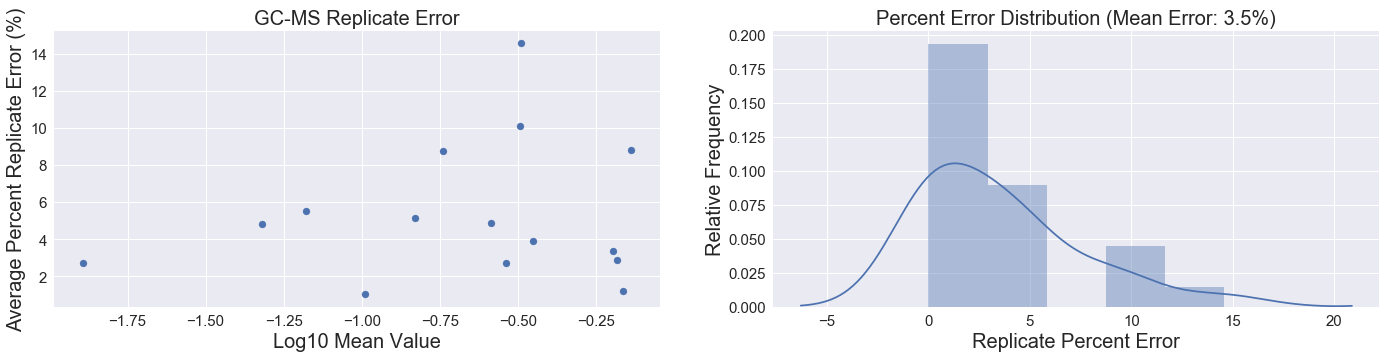

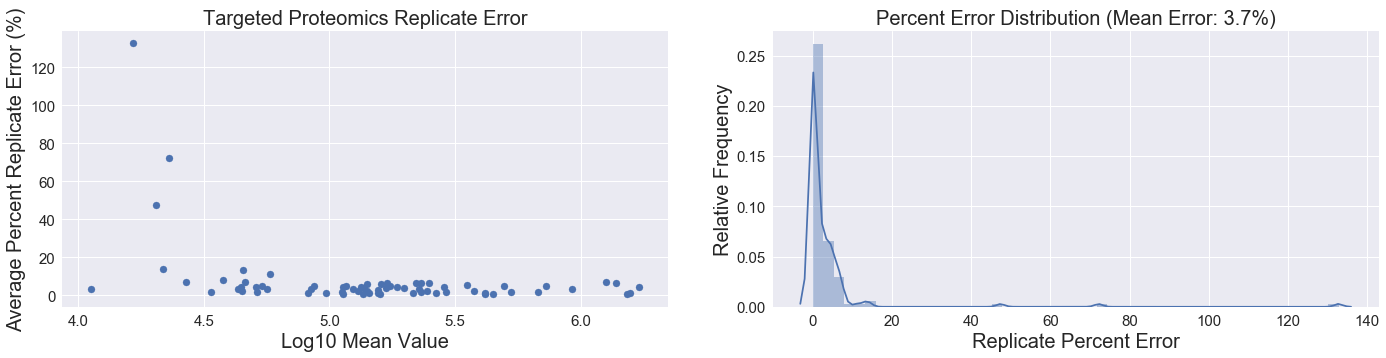

In [48]:
#Analyze Replicates to look at replicate error
import importlib
import utility
importlib.reload(utility)
analyze_replicate_error = utility.analyze_replicate_error

measurements = [column for column in cycle2_df.columns if column[0] != 'Metadata']
measurement_types = ['GC-MS','Targeted Proteomics']
for measurement_type in measurement_types:
    measurement_columns = cycle2_df.columns[cycle2_df.columns.get_level_values(0) == measurement_type]            
    analyze_replicate_error(cycle2_df,measurement_columns,log=True,group_on='Strain',threshold=threshold)
    
    plt.title('{} Replicate Error'.format(measurement_type))
    plt.xlabel('Log10 Mean Value')
    plt.ylabel('Average Percent Replicate Error (%)')
    plt.show()

/Users/zakcostello/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/zakcostello/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

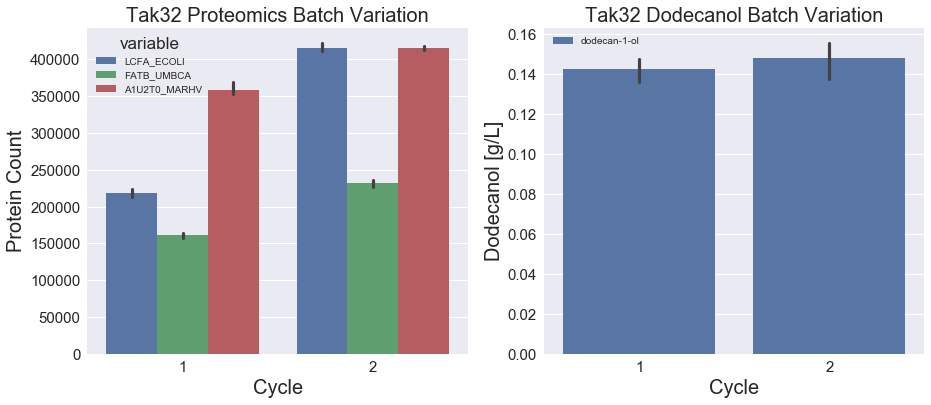

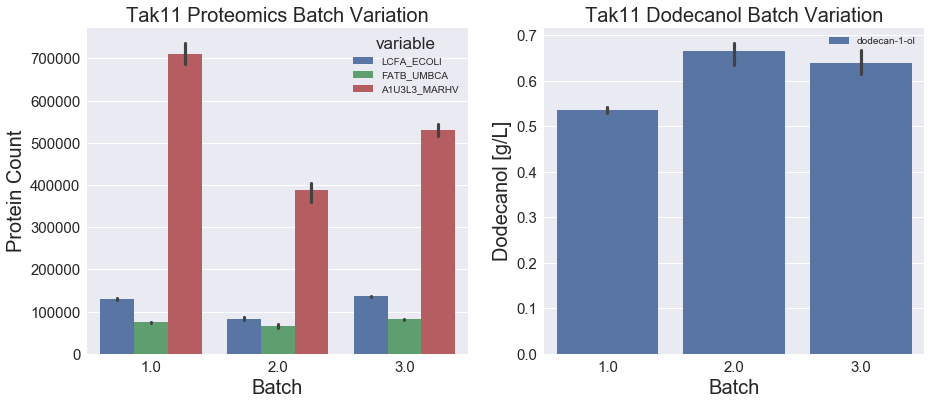

In [49]:
# Tease out Batch Effects Using Control Strains
#

#Create Combined DataFrame with columns Proteomics / Batch / Cycle / Replicate / Production / Strain
new_columns = ['Batch','Strain','Replicate','LCFA_ECOLI','FATB_UMBCA','A1U2T0_MARHV','A1U3L3_MARHV','dodecan-1-ol','Cycle']
columns = [('Metadata','Batch'),('Metadata','Strain'),('Metadata','Replicate'),
           ('Targeted Proteomics','LCFA_ECOLI'),('Targeted Proteomics','sp|Q41635|FATB_UMBCA'),('Targeted Proteomics','tr|A1U2T0|A1U2T0_MARHV'),
           ('Targeted Proteomics', 'tr|A1U3L3|A1U3L3_MARHV'),('GC-MS','dodecan-1-ol')]
batch_df = cycle2_df[columns]

#Add Cycle Information
batch_df.loc[:,('Metadata','Cycle')] = 2

#Pick Out Control Strains For Rows
batch_df = batch_df.loc[batch_df[('Metadata','Strain')].isin(['c1_tak11','c1_tak32'])]
batch_df.columns = new_columns

columns = [('Metadata', 'Batch'),('Metadata','Tak'),('Metadata','Replicate'),
               ('Targeted Proteomics', 'LCFA_ECOLI'),('Targeted Proteomics','FATB_UMBCA'),('Targeted Proteomics','A1U2T0_MARHV'),
               ('Targeted Proteomics', 'A1U3L3_MARHV'),('GC-MS', 'Dodecanoate (n-C12:0)')]
temp_df = df[columns]
temp_df.loc[:,('Metadata','Cycle')] = 1

temp_df = temp_df.loc[temp_df[('Metadata','Tak')].isin([11,32])]
temp_df.columns = new_columns
temp_df['Strain'] = temp_df['Strain'].apply(lambda x: 'c1_tak'+ str(int(x)))

batch_df = pd.concat([batch_df,temp_df])
value_variables = ['LCFA_ECOLI', 'FATB_UMBCA','A1U2T0_MARHV','A1U3L3_MARHV','dodecan-1-ol']
id_variables = ['Batch','Strain','Replicate','Cycle']
plot_batch_df = batch_df.melt(id_vars=id_variables,value_vars=value_variables)

#Plot The Good Stuff
#display(plot_batch_df)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
proteins = ['LCFA_ECOLI', 'FATB_UMBCA', 'A1U2T0_MARHV']
tdf = plot_batch_df.loc[plot_batch_df['Strain']=='c1_tak32'].loc[plot_batch_df['variable'].isin(proteins)]
sns.barplot(x='Cycle',y='value',hue='variable',data=tdf)
plt.title('Tak32 Proteomics Batch Variation')
plt.ylabel('Protein Count')

plt.subplot(1,2,2)
tdf = plot_batch_df.loc[plot_batch_df['Strain']=='c1_tak32'].loc[plot_batch_df['variable']=='dodecan-1-ol']
sns.barplot(x='Cycle',y='value',hue='variable',data=tdf)
plt.legend()
plt.title('Tak32 Dodecanol Batch Variation')
plt.ylabel('Dodecanol [g/L]')

plt.show()

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
proteins = ['LCFA_ECOLI', 'FATB_UMBCA', 'A1U3L3_MARHV']
tdf = plot_batch_df.loc[plot_batch_df['Strain']=='c1_tak11'].loc[plot_batch_df['variable'].isin(proteins)]
sns.barplot(x='Batch',y='value',hue='variable',data=tdf)
plt.title('Tak11 Proteomics Batch Variation')
plt.ylabel('Protein Count')

plt.subplot(1,2,2)
tdf = plot_batch_df.loc[plot_batch_df['Strain']=='c1_tak11'].loc[plot_batch_df['variable']=='dodecan-1-ol']
sns.barplot(x='Batch',y='value',hue='variable',data=tdf)
plt.legend()
plt.title('Tak11 Dodecanol Batch Variation')
plt.ylabel('Dodecanol [g/L]')
plt.show()

In [50]:
# Remove Batch Controls For Downstream Processing
cycle2_df = cycle2_df.loc[~cycle2_df[('Metadata','Strain')].isin(['c1_tak11','c1_tak32','c2b3 9017'])]

### 2.2: Look at correlations between RBS and PRotein Production in second round

0.11333315124842004 0.7108376639586381
0.3800753511710902 -0.4420829338892193


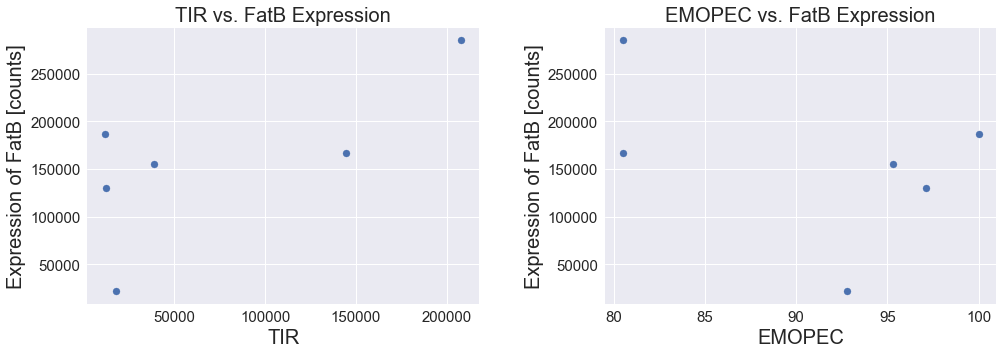

0.1326842141466065 0.578902903071151
0.9770719658622612 0.012229504188145647


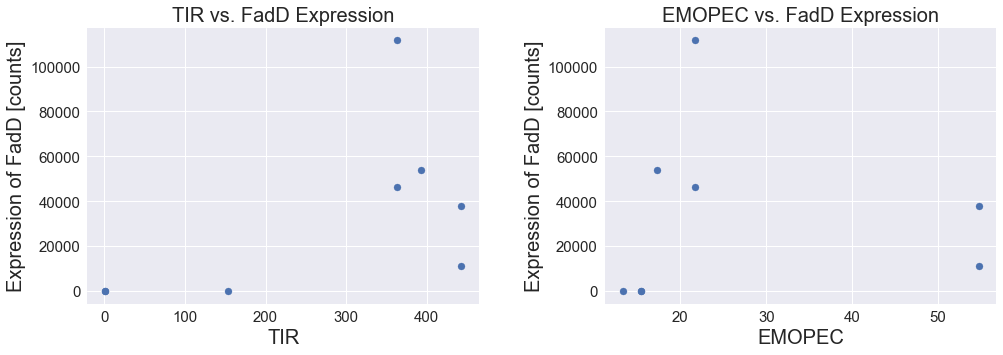

In [51]:
#Load RBS Predicion CSV
rbs_df = pd.read_csv('data/Cycle2RBSPredictions.csv')

#Merge RBS Prediction CSV with FadD and FatB Protein Expression from standard df
cols = [('Metadata', 'Strain'), ('Targeted Proteomics', 'LCFA_ECOLI'), ('Targeted Proteomics', 'sp|Q41635|FATB_UMBCA')]
c2_ave_df = cycle2_df.groupby([('Metadata', 'Strain')]).mean().reset_index()
c2_ave_df = c2_ave_df[cols]
c2_ave_df.columns = ['Strain','FadD','FatB']
rbs_df = pd.merge(rbs_df,c2_ave_df,how='inner',on='Strain')

#Plot Relationship between RBS and TIR/EMOPEC for each condition
for gene in ['FatB','FadD']:
    gene_df = rbs_df.loc[rbs_df['Gene']==gene]
    gene_df = gene_df[np.isfinite(gene_df['TIR'])]
    plt.figure(figsize=(15,6))
    
    for i,rbs_predictor in enumerate(['TIR','EMOPEC']):
    
        plt.subplot(1,2,i+1)
        plt.scatter(gene_df[rbs_predictor],gene_df[gene])
    
        #Calculate Pearson Correlation
        r_val,p_val = pearsonr(gene_df[rbs_predictor],gene_df[gene])
        print(p_val,r_val)
    
        plt.title('{} vs. {} Expression'.format(rbs_predictor,gene))
        plt.xlabel(rbs_predictor)
        plt.ylabel('Expression of {} [counts]'.format(gene))

    plt.tight_layout()
    plt.show()

### 2.3 Look at relationship between proteomics engineering targets and actual strain proteomics

In [52]:
#C2 Target Proteomic Concentrations
protein_multipliers = [[[1/2.73,2.82,1.04],[1/10.2,1.92,1.04]],[[1.49,12.1,1.35],[1.49,8.89,1.35],[1.49,6.60,1.12]]]
strains = ['c1_tak32','c1_tak11']
protein_columns = ['LCFA_ECOLI','FATB_UMBCA','A1U2T0_MARHV','A1U3L3_MARHV']
target_dfs = [pd.DataFrame(),pd.DataFrame()]
for i,strain in enumerate(strains):
    strain_proteins = batch_df[protein_columns].loc[(batch_df['Strain']==strain) & (batch_df['Cycle']==1)]
    strain_proteins = strain_proteins.loc[:, (strain_proteins != 0).any(axis=0)].mean()
    display(strain_proteins.to_frame().transpose())
    for multiplier in protein_multipliers[i]:
        target_dfs[i] = pd.concat([target_dfs[i],strain_proteins.to_frame().transpose()*multiplier])
        
    display(target_dfs[i])

LCFA_ECOLI     FATB_UMBCA   A1U2T0_MARHV
0  217968.333333  161438.333333  358829.666667

LCFA_ECOLI  FATB_UMBCA   A1U2T0_MARHV
0  79841.880342    455256.1  373182.853333
0  21369.444444    309961.6  373182.853333

LCFA_ECOLI  FATB_UMBCA  A1U3L3_MARHV
0    101856.4     69743.2      517552.8

LCFA_ECOLI  FATB_UMBCA  A1U3L3_MARHV
0  151766.036  843892.720    698696.280
0  151766.036  620017.048    698696.280
0  151766.036  460305.120    579659.136

Measurement Type                    A1U2T0_MARHV  A1U3L3_MARHV  ACR1_ACIAD  \
(Metadata, Tak) (Metadata, Batch)                                            
13.0            3.0                 11883.000000           0.0         0.0   
15.0            1.0                  9405.000000           0.0         0.0   
16.0            1.0                 15022.500000           0.0         0.0   
                3.0                  5700.666667           0.0         0.0   
18.0            3.0                197144.000000           0.0         0.0   
19.0            2.0                171616.333333           0.0         0.0   
31.0            2.0                  2726.666667           0.0         0.0   
32.0            2.0                358829.666667           0.0         0.0   
33.0            2.0                245649.666667           0.0         0.0   
34.0            2.0                 24703.000000           0.0         0.0   

Measurement Type                   AHR_ECOLI     FATB_UMBCA     LCFA_ECOLI  \
(Metadata, Tak) (Metadata, Batch)                                            
13.0            3.0                      0.0  215126.333333  201285.333333   
15.0            1.0                      0.0   71856.500000  202178.000000   
16.0            1.0                      0.0   89349.500000   99953.500000   
                3.0                      0.0  100845.666667   95877.666667   
18.0            3.0                      0.0   89131.000000  300955.333333   
19.0            2.0                      0.0   73398.333333  160107.333333   
31.0            2.0                      0.0  184578.333333   95701.333333   
32.0            2.0                      0.0  161438.333333  217968.333333   
33.0            2.0                      0.0  154524.000000  177766.666667   
34.0            2.0                      0.0  166209.333333   67138.666667   

Measurement Type                   Total Protein  
(Metadata, Tak) (Metadata, Batch)                 
13.0            3.0                431916.333333  
15.0            1.0                289612.000000  
16.0            1.0                205678.500000  
                3.0                202750.333333  
18.0            3.0                589020.333333  
19.0            2.0                411690.333333  
31.0            2.0                283548.666667  
32.0            2.0                739292.333333  
33.0            2.0                581051.666667  
34.0            2.0                259572.000000

/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


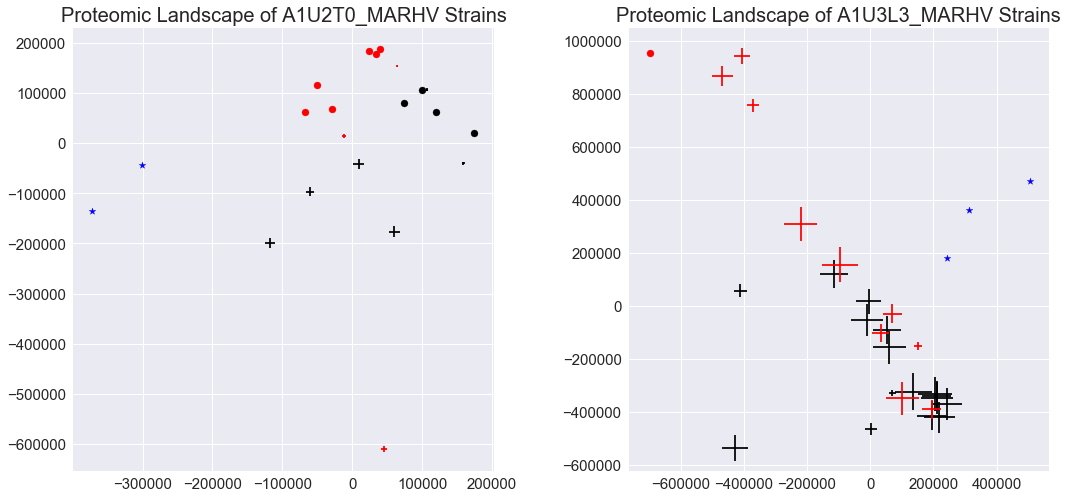

In [53]:
#Plot Projection of PCA Data (X direction is the engineering direction... Y direction describes as much of the remaining variance as possible)
from sklearn.cross_decomposition import PLSRegression as PLS
from sklearn.decomposition import KernelPCA, NMF, FastICA
from sklearn.manifold import MDS

shared_columns = ['LCFA_ECOLI','FATB_UMBCA','A1U2T0_MARHV','A1U3L3_MARHV','Dodecanol']
protein_columns = ['LCFA_ECOLI','FATB_UMBCA','A1U2T0_MARHV','A1U3L3_MARHV']
c1_columns = [('Targeted Proteomics','LCFA_ECOLI'),('Targeted Proteomics','FATB_UMBCA'),
              ('Targeted Proteomics','A1U2T0_MARHV'),('Targeted Proteomics','A1U3L3_MARHV'),
              ('GC-MS','Dodecanoate (n-C12:0)')]
c1_df = df.loc[df[('Metadata','Pathway Variant')].isin([1,2])].groupby([('Metadata','Tak'),('Metadata','Batch')]).mean()
c1_df = c1_df[c1_columns]
c1_df.columns = shared_columns
c1_df['Cycle'] = 1


c2_columns = c1_columns = [('Targeted Proteomics','LCFA_ECOLI'),('Targeted Proteomics','sp|Q41635|FATB_UMBCA'),
              ('Targeted Proteomics','tr|A1U2T0|A1U2T0_MARHV'),('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV'),
              ('GC-MS','dodecan-1-ol')]
c2_df = cycle2_df.groupby([('Metadata','Strain')]).mean()
c2_df = c2_df[c2_columns]
c2_df.columns = shared_columns
c2_df['Cycle'] = 2

X1 = df.loc[df[('Metadata', 'Pathway Variant')]==2].groupby([('Metadata','Tak'),('Metadata','Batch')]).mean()['Targeted Proteomics']
display(X1)
#X1 = X1[columns[0]]

unified_dataframes = [c1_df,c2_df] + target_dfs
ct_df = pd.concat(unified_dataframes)
ct_df = ct_df.fillna(0)
#display(ct_df)
proteins = ['A1U2T0_MARHV','A1U3L3_MARHV']
plt.figure(figsize=(16,8))
for i,protein in zip([0,1],proteins):
    plt.subplot(1,2,i+1)
    pls = MDS(2,n_init=100)
    
    pathway_df = ct_df.loc[(ct_df[protein]>ct_df[proteins[i-1]])]
    X = pathway_df[protein_columns]
    X = X.loc[:, (X != 0).any(axis=0)]
    
    Xt = np.transpose(pls.fit_transform(X))
    pathway_df['X'] = Xt[0]
    pathway_df['Y'] = Xt[1]
    #display(X)
    #plt.scatter(*Xt)
    #plt.show()
    
    color = ['b','k','r']
    marker = ['*','+','+']
    for group in pathway_df.groupby(['Cycle']):
        i = int(group[0])
        
        try:
            X,Y = np.transpose(group[1][['X','Y']].loc[group[1]['Dodecanol']==0].values)
            if i > 0:
                plt.scatter(X,Y,c=color[i],marker='o')
            else:
                plt.scatter(X,Y,c=color[i],marker='*')
        except:
            pass
        
        try:
            X,Y = np.transpose(group[1][['X','Y']].loc[group[1]['Dodecanol'] > 0].values)
            Z = np.transpose(group[1]['Dodecanol'].loc[group[1]['Dodecanol'] > 0].values)
            plt.scatter(X,Y,c=color[i],s=Z**1.5*2000,marker=marker[i])
        except:
            pass
        
    plt.title('Proteomic Landscape of {} Strains'.format(protein))    
    continue
    
    for color,cycle_df in zip(['k','r'],unified_dataframes):
        for production in range(2):
            
            #Get X and Y Values
            if production:
                X = cycle_df[protein_columns].loc[(cycle_df[protein]>0) & (cycle_df['Dodecanol']>0)]
                Y = cycle_df['Dodecanol'].loc[(cycle_df[protein]>0) & (cycle_df['Dodecanol']>0)]
            else:
                X = cycle_df.loc[(cycle_df[protein]>0) & (cycle_df['Dodecanol']==0)]
            X = X.loc[:, (X != 0).any(axis=0)]

            
            #Transform X and Y Values
            if len(X):
                try:
                    Xt = np.transpose(pls.transform(X))
                except:
                    Xt = np.transpose(pls.fit_transform(X))
                    #print(pls.components_)

                #Plot X and Y Values
                if production:
                    plt.scatter(*Xt,s=Y**1.5*2000,marker='+',c=color)
                else:
                    plt.scatter(*Xt,c=color,marker='o')
            
    #Plot Targets
    Xt = np.transpose(pls.transform(target_dfs[i].values))
    plt.scatter(*Xt,marker='*',c='b',s=100)
    
    
    #Format Plot
    plt.title('Proteomic Landscape of {} Strains'.format(protein))
plt.tight_layout()    
plt.show()
    
    

<IPython.core.display.Javascript object>


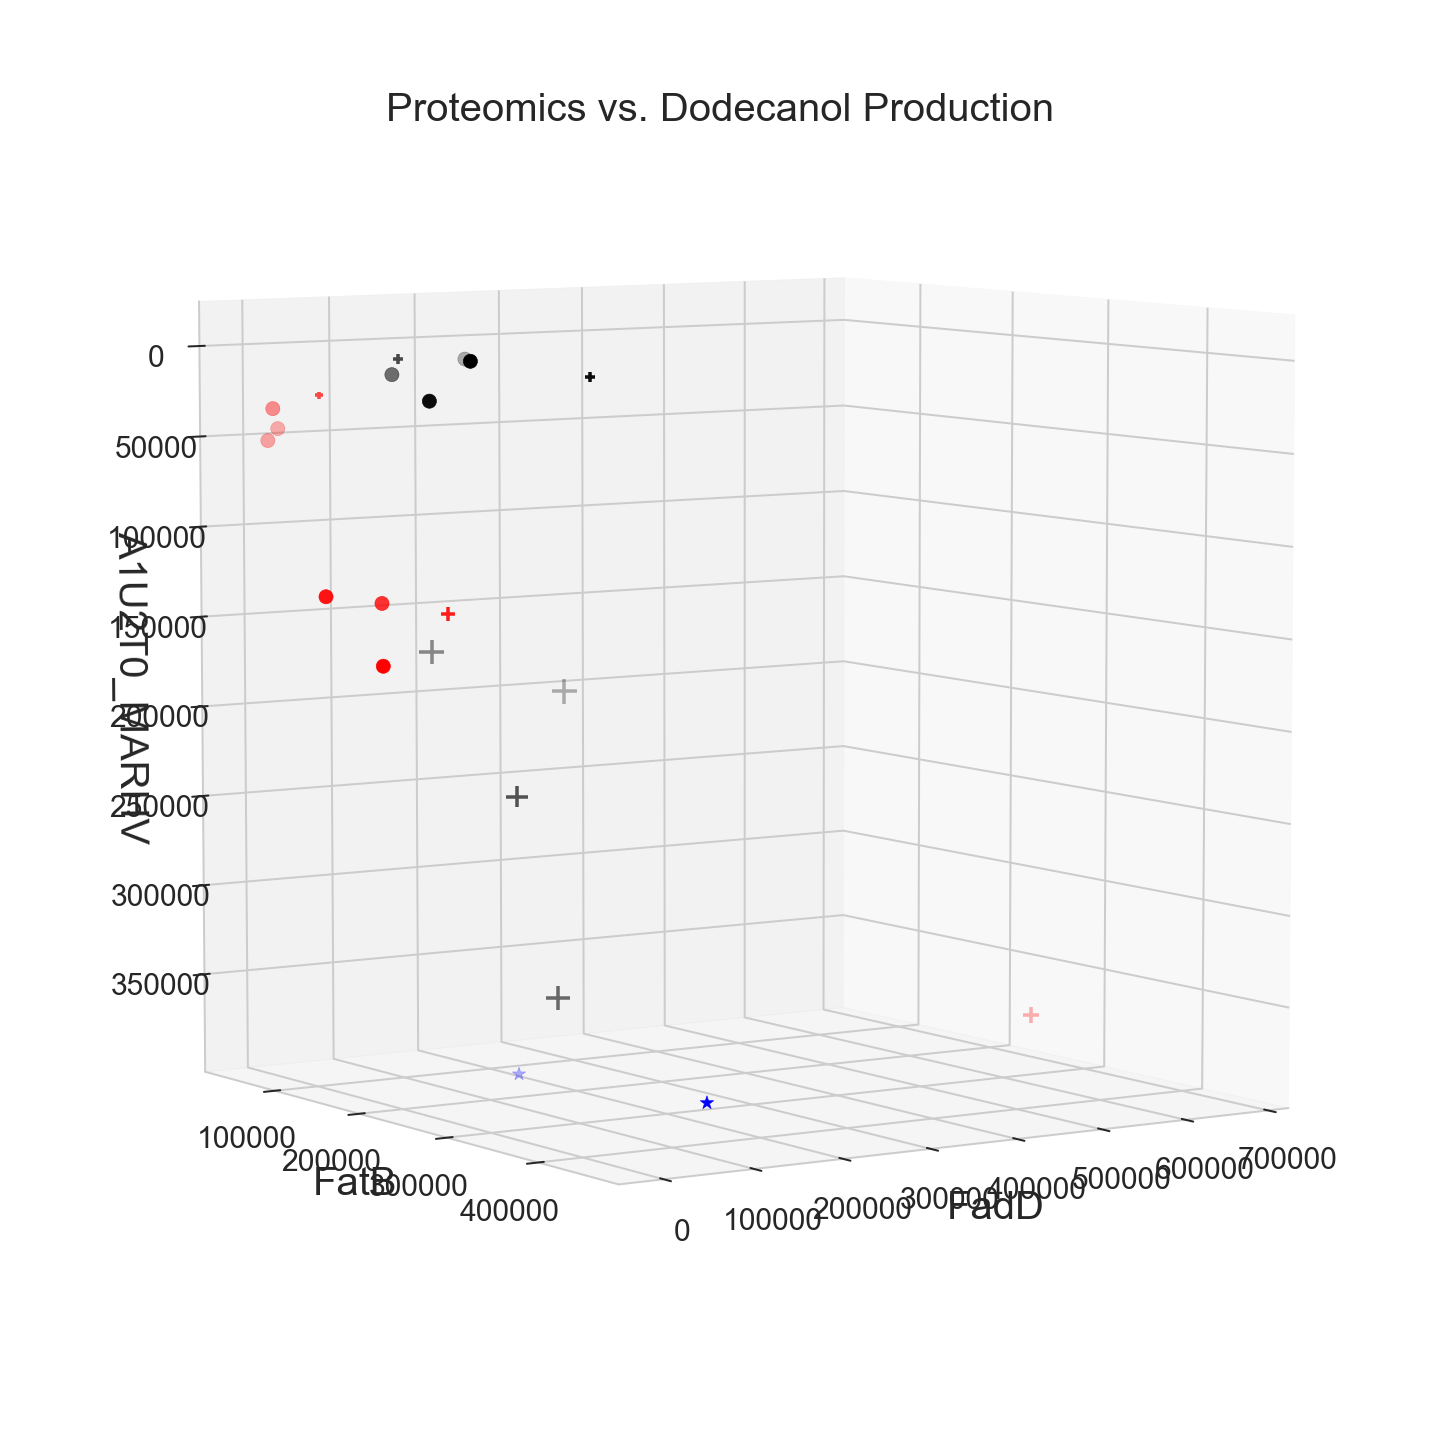

<IPython.core.display.Javascript object>


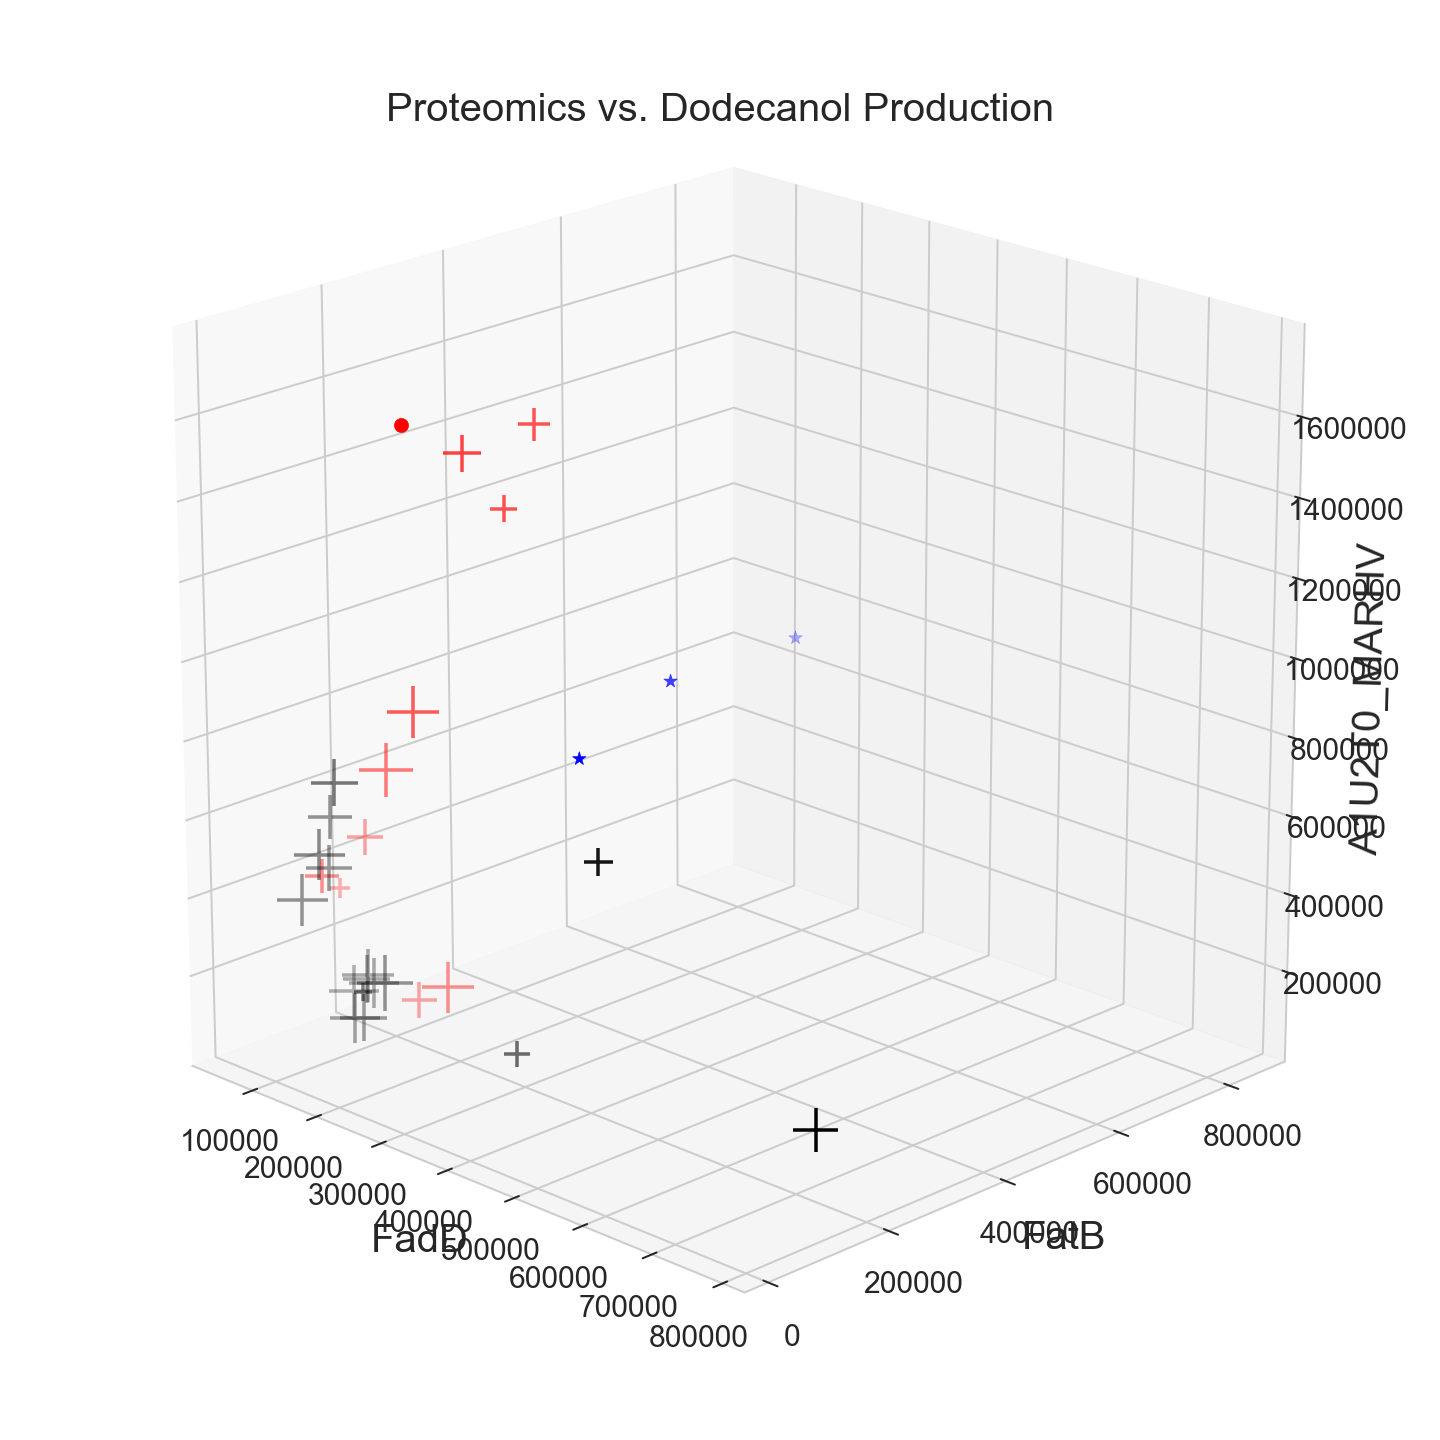

In [68]:
#Plot 3D Protein Plot With Inline Animation...
from importlib import reload
reload(plt)
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

#Plot the First Type of Strains
strain_proteins = ['A1U2T0_MARHV','A1U3L3_MARHV']

for i in range(2):
    pathway_df = ct_df.loc[ct_df[strain_proteins[i]]>ct_df[strain_proteins[i-1]]]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    #Plot Cycle1 data with nonzero production
    sns.set_style('whitegrid')
    pwc1df = pathway_df.loc[pathway_df['Cycle']==1]
    ax.scatter(pwc1df['LCFA_ECOLI'],pwc1df['FATB_UMBCA'],pwc1df[strain_proteins[i]],
               s=pathway_df['Dodecanol']*1000,marker='+',c='k')

    #Plot cycle1 data with zero production
    temp_df = pwc1df.loc[pwc1df['Dodecanol'] == 0]
    ax.scatter(temp_df['LCFA_ECOLI'],temp_df['FATB_UMBCA'],temp_df[strain_proteins[i]],
               s=50,marker='o',c='k')


    #Plot cycle2 data with nonzero production
    temp_df = pathway_df.loc[pathway_df['Cycle']==2]
    ax.scatter(temp_df['LCFA_ECOLI'],temp_df['FATB_UMBCA'],temp_df[strain_proteins[i]],
               s=temp_df['Dodecanol']*1000,marker='+',c='r')

    #Plot cycle2 data with zero production
    temp_df = pathway_df.loc[(pathway_df['Cycle']==2)&(pathway_df['Dodecanol']==0)]
    ax.scatter(temp_df['LCFA_ECOLI'],temp_df['FATB_UMBCA'],temp_df[strain_proteins[i]],
               s=50,marker='o',c='r')

    #Plot Targets
    temp_df = target_dfs[i]
    ax.scatter(temp_df['LCFA_ECOLI'],temp_df['FATB_UMBCA'],temp_df[strain_proteins[i]],
               s=50,marker='*',c='b')

    #Format Plot
    plt.title('Proteomics vs. Dodecanol Production')
    plt.xlabel('FadD')
    plt.ylabel('FatB')
    ax.set_zlabel(strain_proteins[0])
    plt.tight_layout()
    plt.show()


## 2.3 Evaluate Model Accuracy from First Round

Use the models trained on data from the first round to predict the production of the actual proteomics data from Cycle 2.  The predictions are compared to the actual production. 

Percent of Error Max: 0.93


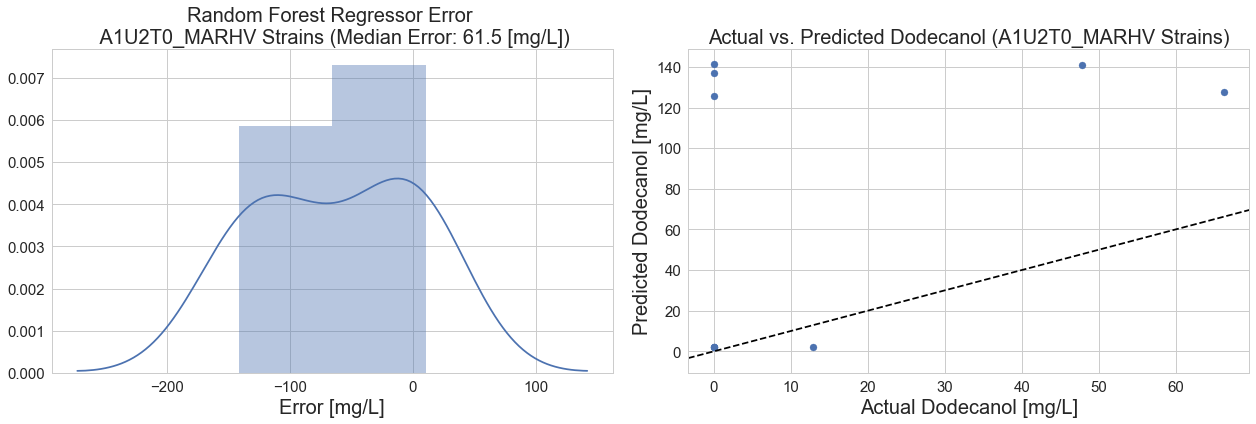

Percent of Error Max: 0.86


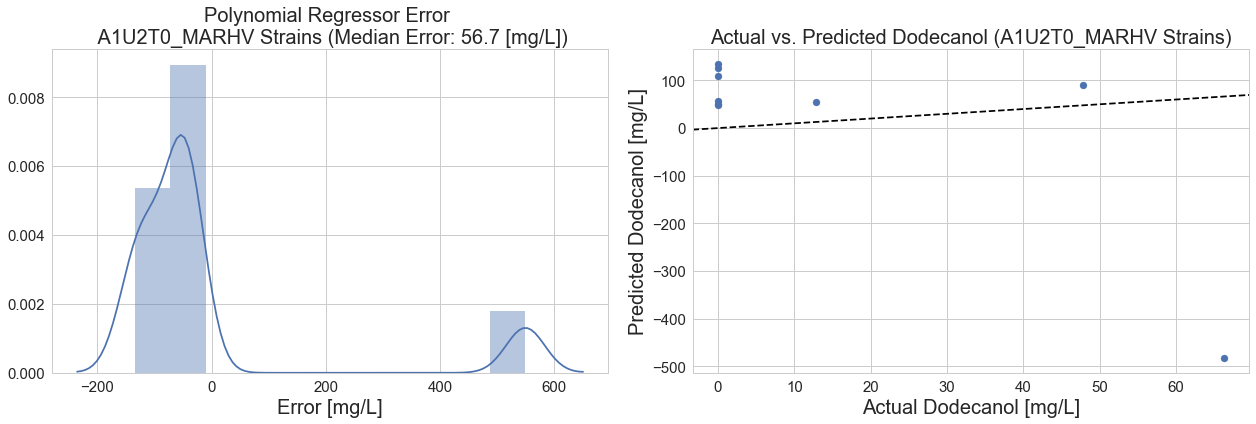

Percent of Error Max: 4.95


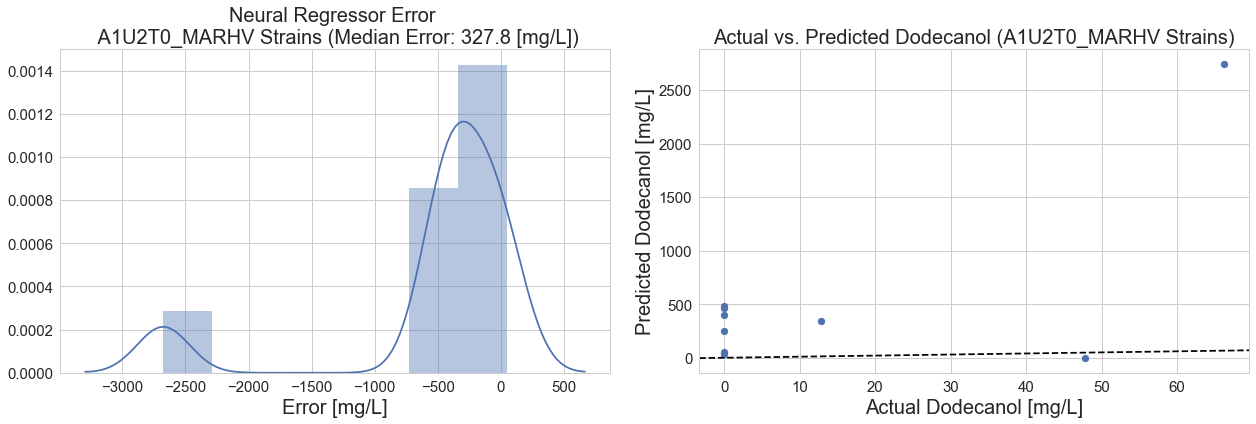

Percent of Error Max: 1.10


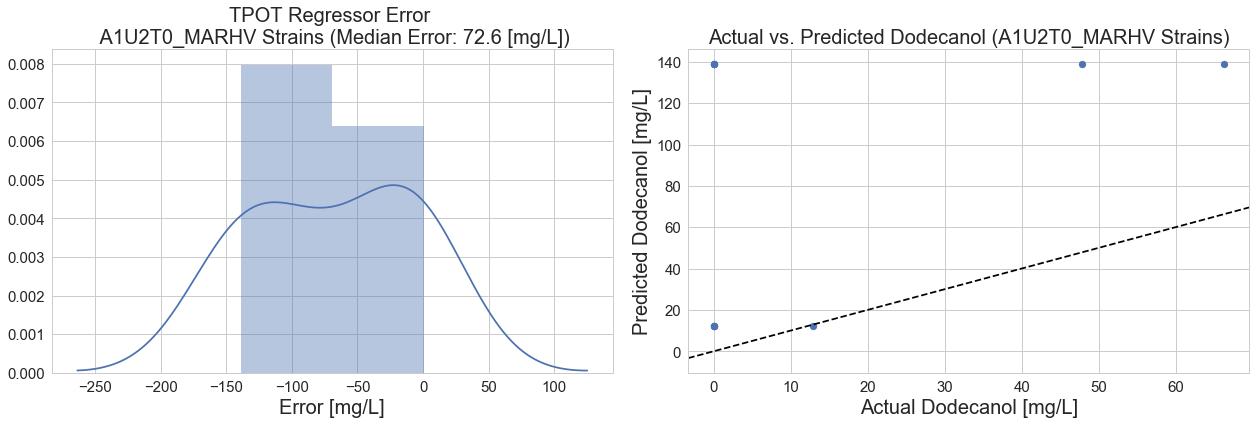

Percent of Error Max: 0.28


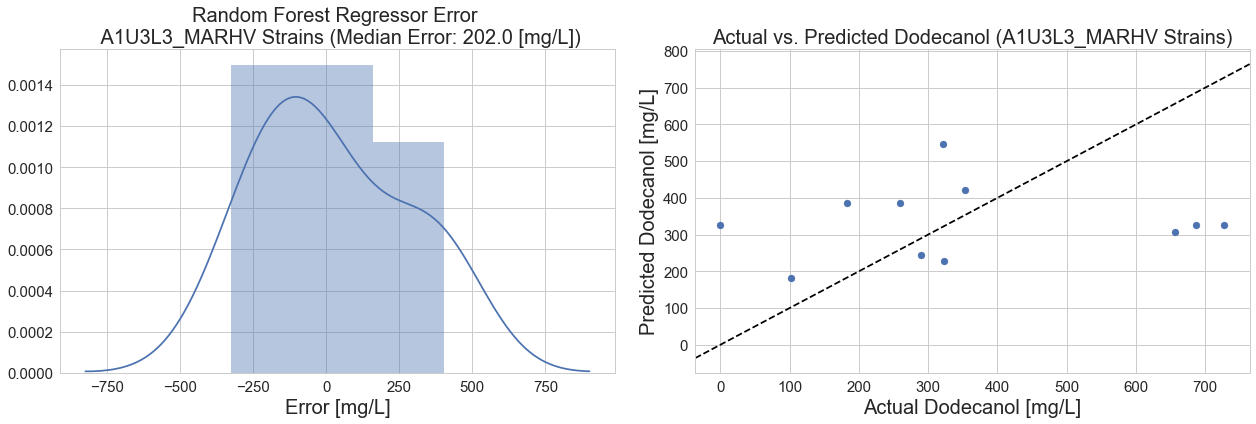

Percent of Error Max: 1.07


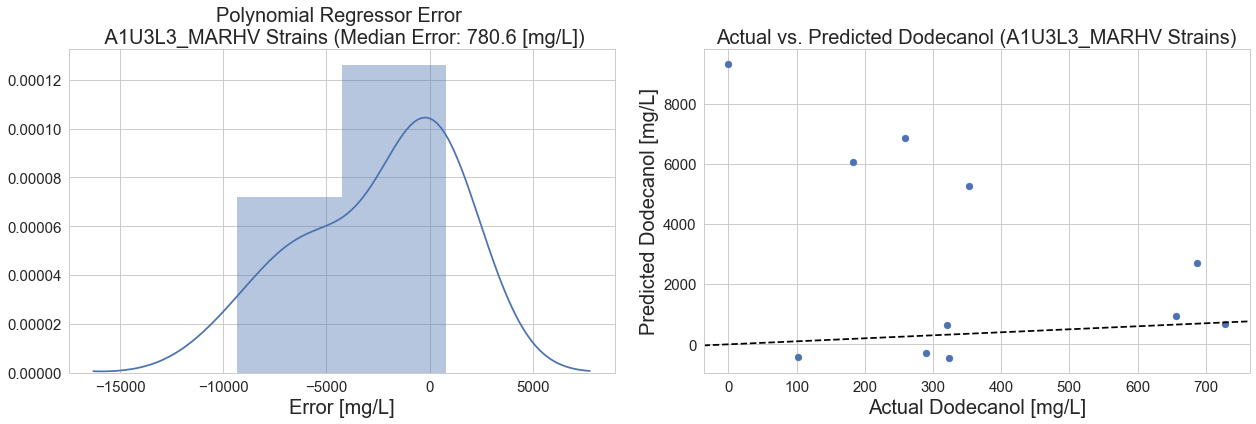

Percent of Error Max: 0.93


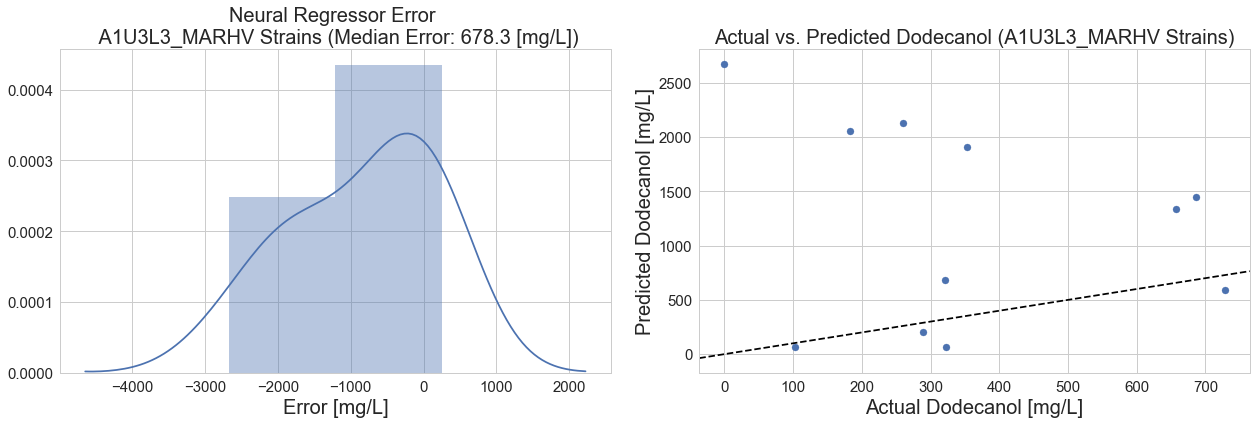

Percent of Error Max: 0.13


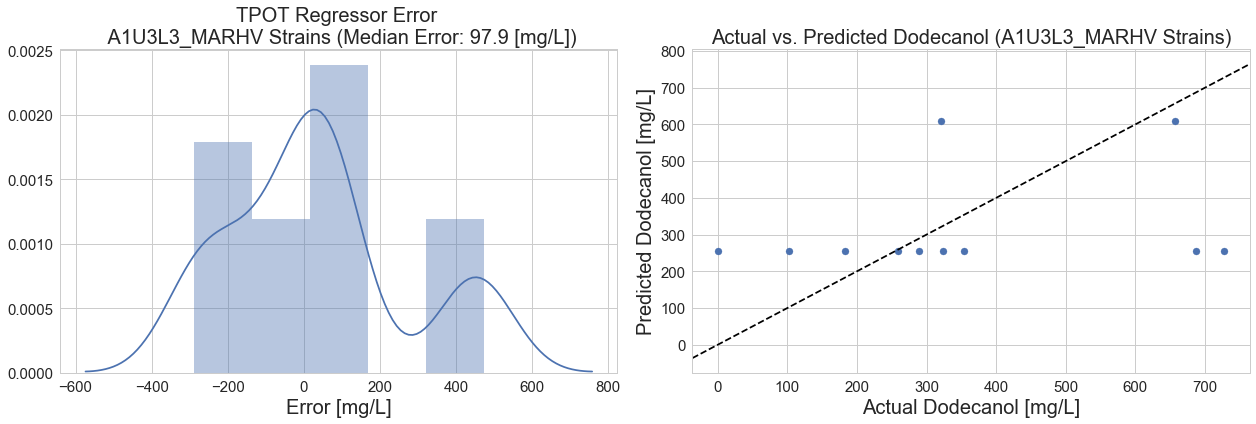

In [58]:
#Get Art Objects For best models (use ART.predict...)
features = [['sp|Q41635|FATB_UMBCA','LCFA_ECOLI','tr|A1U2T0|A1U2T0_MARHV'],['sp|Q41635|FATB_UMBCA','LCFA_ECOLI','tr|A1U3L3|A1U3L3_MARHV']]

#mean_df = 
c2p1df = cycle2_df.loc[cycle2_df[('Targeted Proteomics','tr|A1U2T0|A1U2T0_MARHV')] > cycle2_df[('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV')]]
mean_c2p1df = c2p1df.groupby([('Metadata','Strain')]).mean()
#display(mean_c2p1df)

c2p2df = cycle2_df.loc[cycle2_df[('Targeted Proteomics','tr|A1U3L3|A1U3L3_MARHV')] > cycle2_df[('Targeted Proteomics','tr|A1U2T0|A1U2T0_MARHV')]]
mean_c2p2df = c2p2df.groupby([('Metadata','Strain')]).mean()
#display(mean_c2p2df)


for pathway in range(2):
    feature_set = features[pathway]
    model_df = model_evals[pathway].model_df
    if pathway == 0:
        c2df = mean_c2p1df
    else:
        c2df = mean_c2p2df
        
    #Use Each of the Models To Make Predictions based on Old Data...
    X = c2df['Targeted Proteomics'][feature_set]
    Y = c2df['GC-MS']

    #plt.figure(figsize=(15,15))
    for model,name in zip(model_df['Model'],model_df.index):
        plt.figure(figsize=(18,6))

        #print(name,pathway)
        #print(np.mean(abs(err))*1e3,(np.mean(err)/np.std(Y)*100).values[0])

        Yp = model.predict(X)
        err = (np.transpose(Y.values)-Yp)[0]*1e3
        print('Percent of Error Max: {:0.2f}'.format(np.median(abs(err))/np.max(Y.values)/1e3))
        #print(np.transpose(Y.values))
        #print(Yp)
        #print(err)
        
        
        #Plot distplot
        plt.subplot(1,2,2)
        
        plt.scatter(Y*1000,Yp*1000)
        scatter_ax = plt.gca()

        ax = plt.gca()
        xmin,xmax = ax.get_xlim()
        
        
        plt.subplot(1,2,1)
        sns.distplot(err)
        distplot_ax = plt.gca()
    
    #if pathway==0:
    #    scatter_ax.set_ylim([-10,150])
    
        scatter_ax.set_title('Actual vs. Predicted Dodecanol ({} Strains)'.format(proteins[pathway]))
        scatter_ax.set_xlabel('Actual Dodecanol [mg/L]')
        scatter_ax.set_ylabel('Predicted Dodecanol [mg/L]')
        scatter_ax.plot([xmin,xmax],[xmin,xmax],'k--')
        scatter_ax.set_xlim([xmin,xmax])
        
        distplot_ax.set_title('{} Error \n {} Strains (Median Error: {:0.1f} [mg/L])'.format(name,proteins[pathway],np.median(abs(err))))
        distplot_ax.set_xlabel('Error [mg/L]')
        
        plt.tight_layout()
        plt.show()
        
#plt.tight_layout()
#plt.show()
        
#X = mean_c2p2df['Targeted Proteomics'][features[1]]
#Y = mean_c2p2df['GC-MS'].values
#display(art.model_df)
#Yp = model_evals[1].best_model.predict(X)
#err = (Y-Yp)[0]
#print(err)
#sns.distplot(err)
#plt.show()

#plt.scatter(Y,Yp)
#plt.xlim(0,0.8)
#plt.ylim(0,0.8)
#plt.show()

In [56]:
#